## Rakeshwer's Master Thesis 2022: 

### "Time Series Prediction with ANNs on non-linear and non-stationary Time Series"

**Note:** Former working title was slightly different: "Predicting Regime Shifts for non-linear and non-stationary Time Series with Artificial Neural Networks".

**Research Questions:**

- **Q0:** Set the benchmark: How do **naive heuristics** perform? Try naive buy&hold strategy, which means being always long. Then the accuracy is supposed to be the relative amount of UP movements. Then - in addition to naive buy&hold - take majority vote of last *k* days movement as predictor for next day. What accuracy do we achieve with that? And do we already outperform the naive buy&hold approach? Get baselines for Train / Validation / Test data seperately for both heuristics and all four targets.
- **Q1:** Can we predict trends in stock price movements from their own history alone? (open, high, low, close, range, traded shares, observed volatility, moving averages, RSI, MACD, Bollinger limits) —> We expect to fail and get only poor accuracy (50%). These are all **technical features**.
- **Q2:** Do **external features** help improving accuracy? (mostly macroeconomic indices: GDP, inflation expectation, interest rates,...)
- **Q3:** If we still get poor results, why and where do our models fail? Do we find similarities in terms of patterns or regimes, in which our model performs better or worse? (e.g. high volatility regime,...) Start with analysing samples with highest loss (deviation of prediction from true target), then apply (subspace-)clustering in input feature space.
- **Q4:** And eventually we want to make use of our models and try to set up some trading model, that beats the market (= naive buy-and-hold). Plot cumulative outperformance, cumulative gain from naive buy-and-hold and closing price history (abs values), to recognize, in which market situations our model performs best.

**Outline:**

Here we still to tackle the first question. Before we start, we need to import data from *csv* file - preprocessed in EXCEL. **Note:** Start with S&P500 data history at Jan 7th, 1985, since from there on we have all values available. The limiting factor is Baltic Dry Index. Without that we could start in April 1982, since from there on we find open/high/low/close/vol on [Yahoo Finance](https://finance.yahoo.com/quote/%5EGSPC/history?p=%5EGSPC). Then:

Then we extend the basic setup from notebook 01 to a more functional form. This allows us to perform **multi-run experiments** on each setup to **optimize some hyperparameters**:

- input length
- model architecture: number of feature maps in CNN layers, filter sizes, number of fc or LSTM units
- activation functions
- number of epochs, batch_size, learning_rate
- loss function (classic mse or custom mse)

Here we only focus on optimizing **input length** for different target horizons (1d / 5d / 10d / 20d) on **close (rel. chg.) as single input features**.

And since we expect only poor results (close to random guessing), we will perform a second multirun experiment on a **quasi-optimal** parameter setting: The idea is to check, if there are phases with higher / lower prediction accuracy, so called **regimes**. 

### Tech Preamble

In [17]:
import sys
import datetime
import numpy as np
from os.path import join
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import TimeDistributed, Input, Dense, Conv1D, Conv2D, AveragePooling1D, MaxPooling1D, MaxPooling2D, Dropout, Flatten, Activation, BatchNormalization, GaussianNoise, LeakyReLU
from tensorflow.keras.layers import concatenate
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import SGD, Adam, Adadelta, Adagrad, Nadam, RMSprop, schedules
from tensorflow.keras.utils import to_categorical
import tensorflow.keras.datasets as tfds
import tensorflow.keras.initializers as tfi
import tensorflow.keras.regularizers as tfr
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import backend as K
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import train_test_split

### Import data

In [18]:
# Define path to data folder:
path_to_data = "../data"

# Import data from csv file:
data = np.genfromtxt(join(path_to_data,'SP500_InputFeatures_Targets.csv'), delimiter=';', skip_header=1)

In [19]:
# Check dimensions:
print("data shape (samples, features): ", data.shape)
print("\nfirst row: \n", data[0])

print("\nfeatures [column number]:")
print("=========================")
print("[0] - year")
print("[1] - open (abs)")
print("[2] - high (abs)")
print("[3] - low (abs)")
print("[4] - close (abs)")
print("[5] - close (rel chg)")
print("[6] - vol (abs)") # number of traded shares
print("[7] - vol (rel chg)")
print("[8] - range (abs)") # high - low
print("[9] - range (rel)") # range (abs) / close (abs)
print("[10] - target 1d (rel chg)")
print("[11] - target 5d (rel chg)")
print("[12] - target 10d (rel chg)")
print("[13] - target 20d (rel chg)")
print("[14] - close (abs) moving average 20d")
print("[15] - close (abs) moving average 50d")
print("[16] - close (abs) moving average 100d")
print("[17] - close (abs) moving average 200d")
print("[18] - dist (rel) of close (abs) to moving average 20d")
print("[19] - dist (rel) of close (abs) to moving average 50d")
print("[20] - dist (rel) of close (abs) to moving average 100d")
print("[21] - dist (rel) of close (abs) to moving average 200d")
print("[22] - RSI with 14d lookback")
print("[23] - Bollinger dist (rel) of close (abs) to its moving average 20d - expressed in std devs")
print("[24] - Bollinger short signal")
print("[25] - Bollinger long signal")
print("[26] - Combined Bollinger short/long signal")
print("[27] - Consumer Confidence")
print("[28] - Inflation rate YoY")
print("[29] - Inflation rate MoM")
print("[30] - Inflation expectation (short term)")
print("[31] - Consumer Price Index (abs)")
print("[32] - Consumer Price Index (rel chg)")
print("[33] - Producer Prices change YoY")
print("[34] - GDP growth rate QoQ")
print("[35] - Unemployment rate (abs)")
print("[36] - Unemployment rate (rel chg)")
print("[37] - FED Funds rate (abs)")
print("[38] - FED Funds rate (change)")
print("[39] - M0 money supply (abs)")
print("[40] - M0 money supply (rel chg)")
print("[41] - 10y US Bond yield (abs)")
print("[42] - 10y US Bond yield (change)")
print("[43] - Oil price (abs)")
print("[44] - Oil price (rel chg)")
print("[45] - Business Confidence")
print("[46] - Philly FED Index")
print("[47] - Federal Debt relative to GDP")
print("[48] - Baltic Dry Index (abs)")
print("[49] - Baltic Dry Index (rel chg)")
print("[50] - Dist (rel) of volume (abs) to its moving average 20d - expressed in std devs")

data shape (samples, features):  (9406, 51)

first row: 
 [ 1.98500000e+03  1.63680000e+02  1.64710000e+02  1.63680000e+02
  1.64240000e+02  3.42131000e-03  8.61900000e+07  1.12416107e-01
  1.03000000e+00  6.27131000e-03 -1.52216300e-03  3.81758400e-02
  6.69142720e-02  9.80881640e-02  1.64820000e+02  1.65369600e+02
  1.65455200e+02  1.60508200e+02 -3.51899000e-03 -6.83076000e-03
 -7.34458600e-03  2.32499020e-02  5.77415074e-01 -3.02335523e-01
  0.00000000e+00  0.00000000e+00  0.00000000e+00  9.29000000e+01
  3.90000000e-02  2.00000000e-03  3.30000000e-02  1.05300000e+02
  7.65550200e-03  1.66000000e-02  3.30000000e-02  7.30000000e-02
  1.38888890e-02  8.25000000e-02 -5.00000000e-03  2.04800000e+05
  2.09371880e-02  1.14700000e-01 -1.80000000e-03  2.55600000e+01
  1.50913420e-02  5.06000000e+01  2.10000000e+00  3.96000000e-01
  9.98000000e+02 -2.00000000e-03 -2.95289790e-02]

features [column number]:
[0] - year
[1] - open (abs)
[2] - high (abs)
[3] - low (abs)
[4] - close (abs)
[5] - 

In [20]:
# Extract year for seperating data into train / validation / test sets
year = data[:,0]

## Extract close (rel chg) as input feature.
# [5] - close (rel chg)
# [7] - vol (rel chg)
# [9] - range (rel)

inputs = data[:,(5,7,9)]

## Extract target values for 1d / 5d / 10d / 20d as rel chg:
# [10] - target 1d (rel chg)
# [11] - target 5d (rel chg)
# [12] - target 10d (rel chg)
# [13] - target 20d (rel chg)

targets = data[:,10:14]

# Check dimensions:
print("year shape (samples): ", year.shape)
print("inputs shape (samples, input features): ", inputs.shape)
print("targets shape (samples, output features): ", targets.shape)

year shape (samples):  (9406,)
inputs shape (samples, input features):  (9406, 3)
targets shape (samples, output features):  (9406, 4)


### Define function to split data, custom loss and evaluation metrics

In [21]:
# Define function to split time series 'sequence' into 'n_steps'
def split_sequence(sequence, n_steps):
    X = list()
    for i in range(len(sequence)):
        # Find the end of this pattern
        end_ix = i + n_steps
        # Check if we are beyond the sequence
        if end_ix > len(sequence):
            break
        # Gather input and output parts of the pattern
        seq_x = sequence[i:end_ix]
        X.append(seq_x)
    return np.array(X)

In [22]:
### Define custom loss function and evaluation metrics:


## Our trading model would imply going "long" if the model predicts an up movement and going "short" else.

# If prediction and target have same sign, we are actually not losing money, which should be reflected as 
# zero loss in the loss function. Whereas using the classical mse loss would assign a positive loss value if
# prediction and target point in the same direction - but deviate.
# In our trading model we only lose money if the prediction was indicating an up movement and the market declines.
# In this case we have a negative target value and we find loss = -target (to have a positive loss value).
# In addition to that we have a second scenario where we lose money: If the model indicated a down movement and
# the market gains, we have a positive target value that equals the loss. Hence loss = target (positive loss value).

# This is encountered in the following customized loss function:
def custom_loss(y_true, y_pred):
    
    # Get sign of targets (y_true)
    eval = K.sign(y_true)
    
    # Need to switch dtype to float32:
    eval = K.cast(eval, dtype='float32')
    
    # Get boolean expression: target != prediction?
    eval = K.not_equal(eval, K.sign(y_pred))
    
    # Convert boolean expression to float32
    eval = K.cast(eval, dtype='float32')
    
    # Multiply with targets (y_true), again need to switch dtype to fload32
    eval = eval * K.cast(K.abs(y_true), dtype='float32')
    
    return eval


# Try instead to adjust the classical mse loss: It shall have non-zero loss only if prediction and target deviate.
# Do this with a mask.
def custom_mse(y_true, y_pred):
    
    # Calculate mse as squared deviation of predictions from targets:
    mse = K.square(y_true - y_pred)
    
    # Need to switch dtype to float32:
    mse = K.cast(mse, dtype='float32')
    
    # Get sign of predictions (y_pred)
    eval1 = K.sign(y_pred)
            
    # Get sign of targets (y_true)
    eval2 = K.sign(y_true)
    
    # Need to switch dtype to float32:
    eval2 = K.cast(eval2, dtype='float32')
    
    # Get boolean expression: target != prediction?
    mask = K.not_equal(eval1, eval2)
    mask = K.cast(mask, dtype='float32')
    
    # Get adjusted mse:
    eval = mask * mse
    
    return eval


# According to our trading model (described above), we can define the gain function for our strategy:
def gain(y_true, y_pred):
    
    eval = K.sign(y_pred) * y_true
    
    return eval


# The outperformance compared to the naive buy-and-hold strategy is given by:
def outperformance(y_true, y_pred):
    
    eval = (K.sign(y_pred) - 1) * y_true
    
    return eval


# And the accuracy is given by:
def accuracy(y_true, y_pred):
    
    # Get sign of targets (y_true)
    eval = K.sign(y_true)
    
    # Need to switch dtype to float32:
    eval = K.cast(eval, dtype='float32')
    
    # Get boolean expression: target == prediction?
    eval = K.equal(eval, K.sign(y_pred))
    
    # Convert boolean expression to float32
    eval = K.cast(eval, dtype='float32')
    
    return eval

### Define functions for CNN/fc and CNN/LSTM models

In [23]:
def set_CNN_fc(CNN_filters, CNN_kernel_sizes, fc_units, 
           n_epochs, batch_size, learning_rate, loss_function):
    """
    Sets up CNN/fc model. Can be used for multi-run experiments.
    
    Parameters:
    ===========
    CNN_filters: Array of integer numbers to specify the number of feature maps in all CNN layers.
    CNN_kernel_sizes: Array of integer numbers to specify the filter sizes in all CNN layers.
    fc_units: Array of integer numbers to specify the number of units in all hidden fc layers.
    n_epochs: Integer number to specify the number of epochs for a single run.
    batch_size: Integer number to specify the batch size used for training the model.
    learning_rate: Floating point number to set the learning rate for the optimizer.
    loss_function: String ('mse', 'custom_mse', 'custom_loss') to choose the loss function.
    
    Returns:
    ========
    model
    
    """
    
    # Start model definition:
    model = Sequential()
    
    # Add input layer:
    input_shape = (input_length, len(input_features))
    model.add(Input(shape=input_shape))
    
    # Add CNN layer(s):
    for i in range(len(CNN_filters)):
        model.add(Conv1D(filters=CNN_filters[i], kernel_size=CNN_kernel_sizes[i], strides=1,
                         kernel_initializer=weight_init, bias_initializer = bias_init))
        model.add(BatchNormalization())
        model.add(LeakyReLU(alpha=0.3))
        
        # Add max pooling, if input_length is equal or above 40d to limit number of trainable parameters:
        if input_length >= 40:
            model.add(MaxPooling1D(pool_size=2))
    
    # Flatten CNN output:
    model.add(Flatten())
    
    # Add hidden fc layer(s):
    for i in range(len(fc_units)):
        model.add(Dense(units=fc_units[i], activation = 'sigmoid',
                        kernel_initializer=weight_init, bias_initializer = bias_init))
    
    # Add output unit:
    model.add(Dense(units=1, name = "output", activation = 'linear',
                    kernel_initializer=weight_init, bias_initializer = bias_init))

    # Compile model with desired loss function:
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss=loss_function,
                  metrics=(['mse', custom_mse, custom_loss, gain, outperformance, accuracy]))
   
    return model

In [24]:
def set_CNN_LSTM(CNN_filters, CNN_kernel_sizes, LSTM_units, 
           n_epochs, batch_size, learning_rate, loss_function):
    """
    Sets up CNN/LSTM model. Can be used for multi-run experiments.
    
    Parameters:
    ===========
    CNN_filters: Array of integer numbers to specify the number of feature maps in all CNN layers.
    CNN_kernel_sizes: Array of integer numbers to specify the filter sizes in all CNN layers.
    LSTM_units: Array of integer numbers to specify the number of units in all hidden LSTM layers.
    n_epochs: Integer number to specify the number of epochs for a single run.
    batch_size: Integer number to specify the batch size used for training the model.
    learning_rate: Floating point number to set the learning rate for the optimizer.
    loss_function: String ('mse', 'custom_mse', 'custom_loss') to choose the loss function.
    
    Returns:
    ========
    model
    
    """
    
    # Start model definition:
    model = Sequential()
    
    # Add input layer:
    input_shape = (input_length, len(input_features))
    model.add(Input(shape=input_shape))
    
    # Add CNN layer(s):
    for i in range(len(CNN_filters)):
        model.add(Conv1D(filters=CNN_filters[i], kernel_size=CNN_kernel_sizes[i], strides=1,
                         kernel_initializer=weight_init, bias_initializer = bias_init))
        model.add(BatchNormalization())
        model.add(LeakyReLU(alpha=0.3))
        
        # Add max pooling, if input_length is equal or above 40d to limit number of trainable parameters:
        if input_length >= 40:
            model.add(MaxPooling1D(pool_size=2))
    
    # Add hidden LSTM layer(s):
    for i in range(len(LSTM_units)):
        
        # In case we have multiple LSTM layers, we want to pass ALL hidden states to the subsequent LSTM layer.
        # Only for the last (and possibly ONLY) LSTM layer we only need the final hidden states.
        # This can be specified by return_sequences=True/False.
        # So check if we reached the last LSTM layer yet:
        if i < (len(LSTM_units) - 1):
            model.add(LSTM(units=LSTM_units[i], bias_initializer=bias_init, return_sequences=True))
        else:
            model.add(LSTM(units=LSTM_units[i], bias_initializer=bias_init, return_sequences=False))
    
    # Add output unit:
    model.add(Dense(units=1, name = "output", activation = 'linear',
                    kernel_initializer=weight_init, bias_initializer = bias_init))

    # Compile model with desired loss function:
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss=loss_function,
                  metrics=(['mse', custom_mse, custom_loss, gain, outperformance, accuracy]))
   
    return model

In [25]:
def set_LSTM_fc(LSTM_units, fc_units,
           n_epochs, batch_size, learning_rate, loss_function):
    """
    Sets up LSTM/fc model. Can be used for multi-run experiments.
    
    Parameters:
    ===========
    LSTM_units: Array of integer numbers to specify the number of units in all hidden LSTM layers.
    fc_units: Array of integer numbers to specify the number of units in all hidden fc layers.
    n_epochs: Integer number to specify the number of epochs for a single run.
    batch_size: Integer number to specify the batch size used for training the model.
    learning_rate: Floating point number to set the learning rate for the optimizer.
    loss_function: String ('mse', 'custom_mse', 'custom_loss') to choose the loss function.
    
    Returns:
    ========
    model
    
    """
    
    # Start model definition:
    model = Sequential()
    
    # Add input layer:
    input_shape = (input_length, len(input_features))
    model.add(Input(shape=input_shape))
  
    # Add LSTM layer(s):
    for i in range(len(LSTM_units)):
        
        # In case we have multiple LSTM layers, we want to pass ALL hidden states to the subsequent LSTM layer.
        # Only for the last (and possibly ONLY) LSTM layer we only need the final hidden states.
        # This can be specified by return_sequences=True/False.
        # So check if we reached the last LSTM layer yet:
        if i < (len(LSTM_units) - 1):
            model.add(LSTM(units=LSTM_units[i], bias_initializer=bias_init, return_sequences=True))
        else:
            model.add(LSTM(units=LSTM_units[i], bias_initializer=bias_init, return_sequences=False))
    
    # Add hidden fc layer(s):
    for i in range(len(fc_units)):
        model.add(Dense(units=fc_units[i], activation = 'sigmoid',
                        kernel_initializer=weight_init, bias_initializer = bias_init))
    
    # Add output unit:
    model.add(Dense(units=1, name = "output", activation = 'linear',
                    kernel_initializer=weight_init, bias_initializer = bias_init))

    # Compile model with desired loss function:
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss=loss_function,
                  metrics=(['mse', custom_mse, custom_loss, gain, outperformance, accuracy]))
   
    return model

### Pre-process inputs and targets, define model parameters, single-run model

In [26]:
## Set parameters:

# Data pre-processing:
input_features = (0,) # 0: close (rel. chg.), 1: volume (rel. chg.), 2: range (rel.)
target_horizon = (0,) # 0: 1d, 1: 5d, 2: 10d, 3: 20d
input_length = 20

# Model parameters:
weight_init = tfi.glorot_uniform() # Taken as default.
bias_init = tfi.Zeros() # Taken as default.
CNN_filters = [10,20]
CNN_kernel_sizes = [5,5]
fc_units = [20,10]
LSTM_units = [20,10]
n_epochs = 10
batch_size = 20
learning_rate = 0.0001
loss_function = 'mse' # ('mse', custom_mse or custom_loss) to choose the loss function.

In [ ]:
# Select specified input features:
inputs_selected = inputs[:,input_features]

# Select target horizon:
target_selected = targets[:, target_horizon]

# Split input values into sequences of specified input length:
inputs_split = split_sequence(inputs_selected, input_length)

# Adjust data, year and targets: Cut first (input_length - 1) entries
data_cut = data[input_length-1:]
year_cut = year[input_length-1:]
target_cut = target_selected[input_length-1:]

In [ ]:
## Split inputs and targets into train / validation / test sets, according to year:

# Train data: 1985 .. 2009
# Val data:   2010 .. 2019
# Test data:  2020 .. end

train_input = inputs_split[year_cut <= 2009]
val_input = inputs_split[(year_cut >= 2010) & (year_cut < 2020)]
test_input = inputs_split[year_cut >= 2020]

train_target = target_cut[year_cut <= 2009]
val_target = target_cut[(year_cut >= 2010) & (year_cut < 2020)]
test_target = target_cut[year_cut >= 2020]

# Convert to binary targets (up = 1, down = 0):
train_target_bin = (train_target>0).astype(int)
val_target_bin = (val_target>0).astype(int)
test_target_bin = (test_target>0).astype(int)

# Check dimensions:
print("train_input shape (samples, time steps, features): ", train_input.shape)
print("val_input shape (samples, time steps, features): ", val_input.shape)
print("test_input shape (samples, time steps, features): ", test_input.shape)
print("\ntrain_target shape (samples, features): ", train_target.shape)
print("val_target shape (samples, features): ", val_target.shape)
print("test_target shape (samples, features): ", test_target.shape)
print("\ntrain_target_bin shape (samples, features): ", train_target_bin.shape)
print("val_target shape_bin (samples, features): ", val_target_bin.shape)
print("test_target shape_bin (samples, features): ", test_target_bin.shape)

In [ ]:
# Get min and max for ALL input features from TRAIN data:
train_min = np.min(train_input, axis=(0,1))
train_max = np.max(train_input, axis=(0,1))

# Apply min max scaling to train / val / test inputs: Substract min and divide by (max - min)
train_input_scaled = (train_input - train_min) / (train_max - train_min)
val_input_scaled = (val_input - train_min) / (train_max - train_min)
test_input_scaled = (test_input - train_min) / (train_max - train_min)

# Check result:
print("train_input MIN: ", np.round(np.min(train_input_scaled, axis=(0,1)), 2))
print("train_input MAX: ", np.round(np.max(train_input_scaled, axis=(0,1)), 2))
print("\nval_input MIN: ", np.round(np.min(val_input_scaled, axis=(0,1)), 2))
print("val_input MAX: ", np.round(np.max(val_input_scaled, axis=(0,1)), 2))
print("\ntest_input MIN: ", np.round(np.min(test_input_scaled, axis=(0,1)), 2))
print("test_input MAX: ", np.round(np.max(test_input_scaled, axis=(0,1)), 2))

In [ ]:
# Plot histogram of scaled inputs
nBins = 100
fig, axes = plt.subplots(1, 1, figsize=(10,5))
axes.hist(train_input_scaled[:,0], nBins, color="blue")
axes.set_xlabel("Scaled input interval")
axes.set_ylabel("Counts")
axes.set_title("Histogram of scaled train inputs")
plt.show()

In [ ]:
# Plot histogram of targets
nBins = 100
fig, axes = plt.subplots(1, 1, figsize=(10,5))
axes.hist(train_target[:,0], nBins, color="red")
axes.set_xlabel("rel. chg. interval")
axes.set_ylabel("Counts")
axes.set_title("Histogram of target")
plt.show()

In [220]:
# Set up compiled CNN/fc model:
model = set_CNN_fc(CNN_filters, CNN_kernel_sizes, fc_units, n_epochs, batch_size, learning_rate, loss_function)
model.summary()

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_44 (Conv1D)           (None, 16, 10)            60        
_________________________________________________________________
batch_normalization_44 (Batc (None, 16, 10)            40        
_________________________________________________________________
leaky_re_lu_44 (LeakyReLU)   (None, 16, 10)            0         
_________________________________________________________________
conv1d_45 (Conv1D)           (None, 12, 20)            1020      
_________________________________________________________________
batch_normalization_45 (Batc (None, 12, 20)            80        
_________________________________________________________________
leaky_re_lu_45 (LeakyReLU)   (None, 12, 20)            0         
_________________________________________________________________
flatten_12 (Flatten)         (None, 240)             

In [221]:
# Train model on scaled inputs and un-scaled targets:
history = model.fit(train_input_scaled, train_target, epochs=n_epochs, batch_size=batch_size,
                    shuffle=True, verbose=2, validation_data=(val_input_scaled, val_target))

Epoch 1/10
315/315 - 1s - loss: 0.1137 - mse: 0.1137 - custom_mse: 0.0552 - custom_loss: 0.0037 - gain: 4.4532e-04 - outperformance: 8.1252e-05 - accuracy: 0.5363 - val_loss: 0.0261 - val_mse: 0.0261 - val_custom_mse: 0.0129 - val_custom_loss: 0.0030 - val_gain: 4.6322e-04 - val_outperformance: 0.0000e+00 - val_accuracy: 0.5485
Epoch 2/10
315/315 - 0s - loss: 0.0028 - mse: 0.0028 - custom_mse: 0.0017 - custom_loss: 0.0037 - gain: 3.8475e-04 - outperformance: 2.0675e-05 - accuracy: 0.5226 - val_loss: 0.0074 - val_mse: 0.0074 - val_custom_mse: 0.0039 - val_custom_loss: 0.0030 - val_gain: 4.4101e-04 - val_outperformance: -2.2212e-05 - val_accuracy: 0.5485
Epoch 3/10
315/315 - 0s - loss: 0.0014 - mse: 0.0014 - custom_mse: 9.4913e-04 - custom_loss: 0.0038 - gain: 9.9693e-05 - outperformance: -2.6438e-04 - accuracy: 0.4990 - val_loss: 0.0027 - val_mse: 0.0027 - val_custom_mse: 0.0015 - val_custom_loss: 0.0031 - val_gain: 1.2611e-04 - val_outperformance: -3.3712e-04 - val_accuracy: 0.5362
Epo

In [222]:
# Get model predictions:
train_pred = model.predict(train_input_scaled)
val_pred = model.predict(val_input_scaled)

# Convert to binary prediction UP (1) / DOWN (0):
train_pred_bin = (train_pred>0).astype(int)
val_pred_bin = (val_pred>0).astype(int)

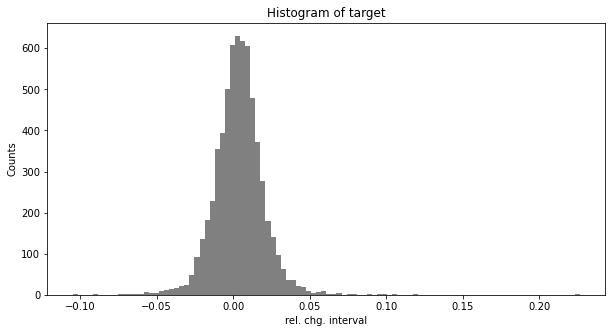

In [223]:
# Plot histogram of predictions
nBins = 100
fig, axes = plt.subplots(1, 1, figsize=(10,5))
axes.hist(train_pred[:,0], nBins, color="grey")
axes.set_xlabel("rel. chg. interval")
axes.set_ylabel("Counts")
axes.set_title("Histogram of predictions")
plt.show()

In [224]:
# Get custom loss, gain, outperformance and accuracy for validation samples:
val_custom_mse = custom_mse(val_target, val_pred)
val_custom_loss = custom_loss(val_target, val_pred)
val_gain = gain(val_target, val_pred)
val_outperformance = outperformance(val_target, val_pred)
val_accuracy = accuracy(val_target, val_pred)

# Check val. target vs. prediction for first 10 validation samples, vs. custom loss, gain, outperformance and acc:
print("         target | prediction | custom mse | custom loss | gain | outperformance | accuracy")
np.concatenate([val_target[:10],val_pred[:10],val_custom_mse[:10],val_custom_loss[:10],
                val_gain[:10],val_outperformance[:10],val_accuracy[:10]],axis=-1)

         target | prediction | custom mse | custom loss | gain | outperformance | accuracy


array([[ 3.11565000e-03, -2.51810439e-03,  3.17391896e-05,
         3.11565003e-03, -3.11565003e-03, -6.23130007e-03,
         0.00000000e+00],
       [ 5.45525000e-04,  1.47743151e-04,  0.00000000e+00,
         0.00000000e+00,  5.45524992e-04,  0.00000000e+00,
         1.00000000e+00],
       [ 4.00126600e-03, -8.25460441e-03,  1.50206353e-04,
         4.00126586e-03, -4.00126586e-03, -8.00253171e-03,
         0.00000000e+00],
       [ 2.88169300e-03, -1.10651739e-03,  1.59058218e-05,
         2.88169296e-03, -2.88169296e-03, -5.76338591e-03,
         0.00000000e+00],
       [ 1.74675500e-03,  1.66212153e-02,  0.00000000e+00,
         0.00000000e+00,  1.74675498e-03,  0.00000000e+00,
         1.00000000e+00],
       [-9.38115700e-03,  5.19683771e-03,  2.12517931e-04,
         9.38115735e-03, -9.38115735e-03, -0.00000000e+00,
         0.00000000e+00],
       [ 8.32585200e-03,  2.61142384e-02,  0.00000000e+00,
         0.00000000e+00,  8.32585245e-03,  0.00000000e+00,
         1.0000000

In [225]:
# Get binary prediction accuracy - in terms of correctly predicted up/down movements:
train_acc = np.sum(train_pred_bin == train_target_bin) / len(train_pred_bin)
val_acc = np.sum(val_pred_bin == val_target_bin) / len(val_pred_bin)

# Get "naive" accuracy, when we always predict an UP movement.
# In other words this reflects the relative amount of UP movements.
train_acc_naiv = np.sum(train_target_bin / len(train_target))
val_acc_naiv = np.sum(val_target_bin / len(val_target))

print("train acc (%): ", np.round(train_acc * 100,1), "%")
print("val acc (%): ", np.round(val_acc * 100,1), "%")
print("\nnaive train acc (%)", np.round(train_acc_naiv * 100,1), "%")
print("naive val acc (%)", np.round(val_acc_naiv * 100,1), "%")

train acc (%):  50.7 %
val acc (%):  49.4 %

naive train acc (%) 53.5 %
naive val acc (%) 54.8 %


### Discussion: Single-run CNN/fc model

The model trains well, find predictions somewhat centered arround *zero*, as the histogram of targets shows. But the accuracy is poor - compared to naive accuracy. Our model is no better than just **random guessing**, if trained only on **close_rel_chg** as single input feature.

Next:

- Try to **replace fc-layers by LSTM-layers** to make it a hybrid CNN/LSTM model.

### Single-run CNN/LSTM model

Model parameters are defined above. Also data pre-processing is taken from previous CNN/fc model pre-processing above.

In [226]:
# Set up compiled CNN/LSTM model:
model = set_CNN_LSTM(CNN_filters, CNN_kernel_sizes, LSTM_units, n_epochs, batch_size, learning_rate, loss_function)
model.summary()

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_46 (Conv1D)           (None, 16, 10)            60        
_________________________________________________________________
batch_normalization_46 (Batc (None, 16, 10)            40        
_________________________________________________________________
leaky_re_lu_46 (LeakyReLU)   (None, 16, 10)            0         
_________________________________________________________________
conv1d_47 (Conv1D)           (None, 12, 20)            1020      
_________________________________________________________________
batch_normalization_47 (Batc (None, 12, 20)            80        
_________________________________________________________________
leaky_re_lu_47 (LeakyReLU)   (None, 12, 20)            0         
_________________________________________________________________
lstm_20 (LSTM)               (None, 12, 20)          

In [227]:
# Train model on scaled inputs and un-scaled targets:
history = model.fit(train_input_scaled, train_target, epochs=n_epochs, batch_size=batch_size,
                    shuffle=True, verbose=2, validation_data=(val_input_scaled, val_target))

Epoch 1/10
315/315 - 5s - loss: 7.2680e-04 - mse: 7.2680e-04 - custom_mse: 5.1355e-04 - custom_loss: 0.0039 - gain: -2.7060e-05 - outperformance: -3.9113e-04 - accuracy: 0.5003 - val_loss: 1.8734e-04 - val_mse: 1.8734e-04 - val_custom_mse: 1.5062e-04 - val_custom_loss: 0.0034 - val_gain: -3.3522e-04 - val_outperformance: -7.9844e-04 - val_accuracy: 0.4642
Epoch 2/10
315/315 - 2s - loss: 3.3904e-04 - mse: 3.3904e-04 - custom_mse: 2.5535e-04 - custom_loss: 0.0038 - gain: 1.3405e-04 - outperformance: -2.3002e-04 - accuracy: 0.5111 - val_loss: 1.4167e-04 - val_mse: 1.4167e-04 - val_custom_mse: 1.0980e-04 - val_custom_loss: 0.0031 - val_gain: 1.1040e-04 - val_outperformance: -3.5282e-04 - val_accuracy: 0.5028
Epoch 3/10
315/315 - 2s - loss: 2.6657e-04 - mse: 2.6657e-04 - custom_mse: 2.0771e-04 - custom_loss: 0.0038 - gain: 2.4248e-04 - outperformance: -1.2159e-04 - accuracy: 0.5134 - val_loss: 2.4384e-04 - val_mse: 2.4384e-04 - val_custom_mse: 1.8170e-04 - val_custom_loss: 0.0030 - val_gain

In [228]:
# Get model predictions:
train_pred = model.predict(train_input_scaled)
val_pred = model.predict(val_input_scaled)

# Convert to binary prediction UP (1) / DOWN (0):
train_pred_bin = (train_pred>0).astype(int)
val_pred_bin = (val_pred>0).astype(int)

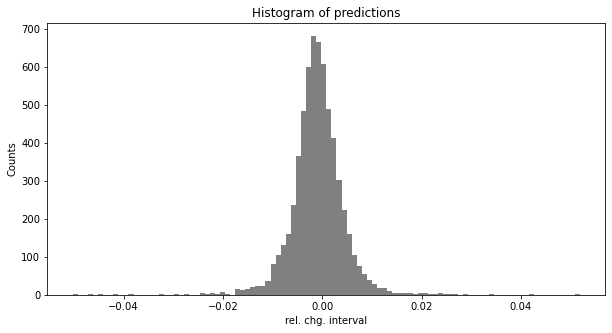

In [229]:
# Plot histogram of predictions
nBins = 100
fig, axes = plt.subplots(1, 1, figsize=(10,5))
axes.hist(train_pred[:,0], nBins, color="grey")
axes.set_xlabel("rel. chg. interval")
axes.set_ylabel("Counts")
axes.set_title("Histogram of predictions")
plt.show()

In [230]:
# Get binary prediction accuracy - in terms of correctly predicted up/down movements:
train_acc = np.sum(train_pred_bin == train_target_bin) / len(train_pred_bin)
val_acc = np.sum(val_pred_bin == val_target_bin) / len(val_pred_bin)

# Get "naive" accuracy, when we always predict an UP movement.
# In other words this reflects the relative amount of UP movements.
train_acc_naiv = np.sum(train_target_bin / len(train_target))
val_acc_naiv = np.sum(val_target_bin / len(val_target))

print("train acc (%): ", np.round(train_acc * 100,1), "%")
print("val acc (%): ", np.round(val_acc * 100,1), "%")
print("\nnaive train acc (%)", np.round(train_acc_naiv * 100,1), "%")
print("naive val acc (%)", np.round(val_acc_naiv * 100,1), "%")

train acc (%):  51.3 %
val acc (%):  50.2 %

naive train acc (%) 53.5 %
naive val acc (%) 54.8 %


### Discussion: Single-run CNN/LSTM model

The model trains well, as the CNN/fc model, find predictions somewhat centered arround *zero*, as the histogram of targets shows. But the accuracy is still very poor - compared to naive accuracy. Our model is no better than just **random guessing**, if trained only on **close_rel_chg** as single input feature.

Next:

- **Switch to binary targets** and make it a classification problem. Need to adjust loss to binary cross entropy then plus need *sigmoid* activation for output unit.

### Try CNN/LSTM model on binary targets

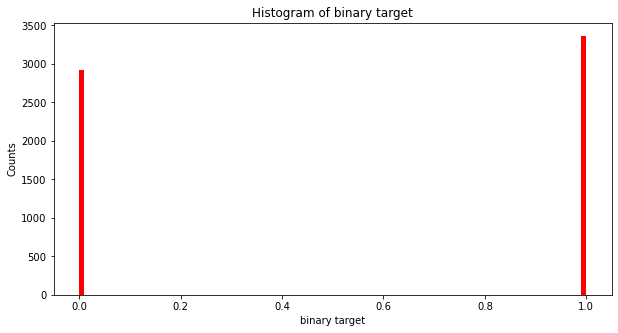

In [231]:
# Plot histogram of binary targets
nBins = 100
fig, axes = plt.subplots(1, 1, figsize=(10,5))
axes.hist(train_target_bin[:,0], nBins, color="red")
axes.set_xlabel("binary target")
axes.set_ylabel("Counts")
axes.set_title("Histogram of binary target")
plt.show()

In [240]:
# Set some parameters for training the model:
n_epochs = 100
batch_size = 100
learning_rate = 0.0001

In [241]:
# Start model definition:
model = Sequential()

# Add input layer:
input_shape = (input_length, len(input_features))
model.add(Input(shape=input_shape))

# Add CNN layer(s):
model.add(Conv1D(filters=10, kernel_size=7, strides=1, kernel_initializer=weight_init, bias_initializer = bias_init))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.3))
#model.add(MaxPooling1D(pool_size=2)) 
model.add(Conv1D(filters=20, kernel_size=4, strides=1, kernel_initializer=weight_init, bias_initializer = bias_init))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.3))
#model.add(MaxPooling1D(pool_size=2)) 
model.add(LSTM(20, bias_initializer="zeros", return_sequences=True))
#model.add(Dropout(0.5))
model.add(LSTM(10))
#model.add(Dropout(0.5))
model.add(Dense(units=1, name = "output", activation = 'sigmoid', kernel_initializer=weight_init, bias_initializer = bias_init))

# with constant lr
model.compile(optimizer=Adam(learning_rate=learning_rate),loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),metrics=['acc'])
model.summary()

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_50 (Conv1D)           (None, 14, 10)            80        
_________________________________________________________________
batch_normalization_50 (Batc (None, 14, 10)            40        
_________________________________________________________________
leaky_re_lu_50 (LeakyReLU)   (None, 14, 10)            0         
_________________________________________________________________
conv1d_51 (Conv1D)           (None, 11, 20)            820       
_________________________________________________________________
batch_normalization_51 (Batc (None, 11, 20)            80        
_________________________________________________________________
leaky_re_lu_51 (LeakyReLU)   (None, 11, 20)            0         
_________________________________________________________________
lstm_24 (LSTM)               (None, 11, 20)          

In [242]:
# Train model on scaled inputs and binary targets:
history = model.fit(train_input_scaled, train_target_bin, epochs=n_epochs, batch_size=batch_size,
                    shuffle=True, verbose=2, validation_data=(val_input_scaled, val_target_bin))

Epoch 1/100
63/63 - 3s - loss: 0.6935 - acc: 0.5153 - val_loss: 0.6902 - val_acc: 0.5485
Epoch 2/100
63/63 - 1s - loss: 0.6923 - acc: 0.5328 - val_loss: 0.6906 - val_acc: 0.5485
Epoch 3/100
63/63 - 1s - loss: 0.6915 - acc: 0.5339 - val_loss: 0.6905 - val_acc: 0.5485
Epoch 4/100
63/63 - 1s - loss: 0.6910 - acc: 0.5345 - val_loss: 0.6903 - val_acc: 0.5485
Epoch 5/100
63/63 - 1s - loss: 0.6905 - acc: 0.5347 - val_loss: 0.6898 - val_acc: 0.5485
Epoch 6/100
63/63 - 1s - loss: 0.6903 - acc: 0.5342 - val_loss: 0.6893 - val_acc: 0.5485
Epoch 7/100
63/63 - 1s - loss: 0.6899 - acc: 0.5356 - val_loss: 0.6893 - val_acc: 0.5485
Epoch 8/100
63/63 - 1s - loss: 0.6896 - acc: 0.5372 - val_loss: 0.6891 - val_acc: 0.5485
Epoch 9/100
63/63 - 1s - loss: 0.6894 - acc: 0.5398 - val_loss: 0.6891 - val_acc: 0.5481
Epoch 10/100
63/63 - 1s - loss: 0.6892 - acc: 0.5391 - val_loss: 0.6893 - val_acc: 0.5477
Epoch 11/100
63/63 - 1s - loss: 0.6891 - acc: 0.5347 - val_loss: 0.6894 - val_acc: 0.5461
Epoch 12/100
63/63 

63/63 - 1s - loss: 0.6785 - acc: 0.5678 - val_loss: 0.6977 - val_acc: 0.5036
Epoch 93/100
63/63 - 1s - loss: 0.6776 - acc: 0.5692 - val_loss: 0.6990 - val_acc: 0.5028
Epoch 94/100
63/63 - 1s - loss: 0.6776 - acc: 0.5657 - val_loss: 0.7003 - val_acc: 0.4917
Epoch 95/100
63/63 - 1s - loss: 0.6774 - acc: 0.5699 - val_loss: 0.6983 - val_acc: 0.4988
Epoch 96/100
63/63 - 1s - loss: 0.6773 - acc: 0.5673 - val_loss: 0.6964 - val_acc: 0.5179
Epoch 97/100
63/63 - 1s - loss: 0.6776 - acc: 0.5670 - val_loss: 0.6974 - val_acc: 0.5052
Epoch 98/100
63/63 - 1s - loss: 0.6769 - acc: 0.5660 - val_loss: 0.6981 - val_acc: 0.5068
Epoch 99/100
63/63 - 1s - loss: 0.6767 - acc: 0.5721 - val_loss: 0.6974 - val_acc: 0.5016
Epoch 100/100
63/63 - 1s - loss: 0.6764 - acc: 0.5686 - val_loss: 0.6960 - val_acc: 0.5183


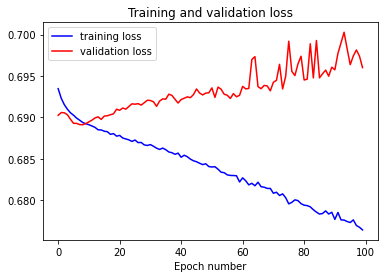

In [243]:
# Plot train and val_loss (bin. cross-entropy)
plt.plot(history.history['loss'], color = 'blue', label = 'training loss')
plt.plot(history.history['val_loss'], color = 'red', label = 'validation loss')
plt.xlabel('Epoch number')
#plt.ylim(0.6, 0.8)
plt.title('Training and validation loss')
plt.legend()
plt.show() 

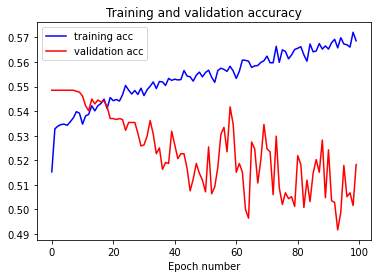

In [244]:
# Plot train and val_acc
plt.plot(history.history['acc'], color = 'blue', label = 'training acc')
plt.plot(history.history['val_acc'], color = 'red', label = 'validation acc')
plt.xlabel('Epoch number')
#plt.ylim(0.6, 0.8)
plt.title('Training and validation accuracy')
plt.legend()
plt.show() 

In [245]:
# Get model predictions:
train_pred = model.predict(train_input_scaled)
val_pred = model.predict(val_input_scaled)

# Convert to binary prediction UP (1) / DOWN (0):
train_pred_bin = (train_pred>0.5).astype(int)
val_pred_bin = (val_pred>0.5).astype(int)

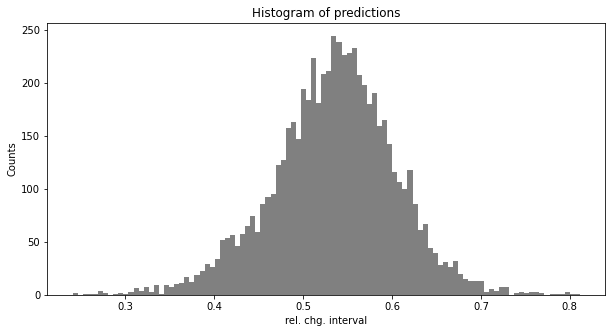

In [246]:
# Plot histogram of predictions
nBins = 100
fig, axes = plt.subplots(1, 1, figsize=(10,5))
axes.hist(train_pred[:,0], nBins, color="grey")
axes.set_xlabel("rel. chg. interval")
axes.set_ylabel("Counts")
axes.set_title("Histogram of predictions")
plt.show()

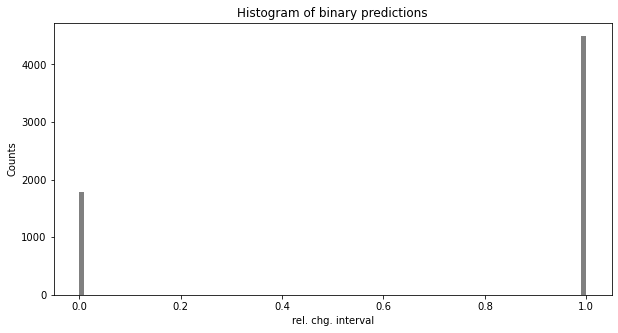

In [247]:
# Plot histogram of predictions - converted to binary predictions: > 0.5 --> UP, <= 0.5 --> DOWN, since we
# use sigmoid activation in final output unit.
nBins = 100
fig, axes = plt.subplots(1, 1, figsize=(10,5))
axes.hist(train_pred_bin[:,0], nBins, color="grey")
axes.set_xlabel("rel. chg. interval")
axes.set_ylabel("Counts")
axes.set_title("Histogram of binary predictions")
plt.show()

### Discussion: Single-run CNN/LSTM model on BINARY targets

Opposed to the CNN/fc and CNN/LSTM models on continuous targets, we find an increasing train accuracy if we work with binary targets and hence switch from a regression to a classification problem.

But the model shows clear signs of overfitting and just memorizes train inputs with increasing number of training epochs. Validation accuracy drops to 50%, hence this model is still not better than random guessing.

Possibilities to avoid / reduce overfitting:

- Add **Dropout** to LSTM part of the model.
- Add **weight and bias regularization** in all layers.

### CNN/fc model: Set up model, first multi-run experiment on fixed parameter set to optimize input length

Fix base parameters as follows:

- weight_init = tfi.glorot_uniform()
- bias_init = tfi.Zeros()
- CNN_filters = [10,20]
- CNN_kernel_sizes = [5,5]
- fc_units = [20,10]
- n_epochs = 20
- batch_size = 100
- learning_rate = 0.0001
- loss_function = 'mse'

Perform multi-run experiment with **n_runs = 10**. Look for **optimal input length** from [10, 15, 20, 25, 30, 40, 50, 60, 80, 100] **for all target length** 1d/5d/10d/20d seperately. Use **close_rel_chg** as **only input feature** for now and regular **mse loss**.

**SAVED RESULTS:** histories_multirun_01.npy

In [2]:
## Set parameters:

# Number of runs for each setting:
n_runs = 10

# Fixed model parameters:
weight_init = tfi.glorot_uniform() # Taken as default.
bias_init = tfi.Zeros() # Taken as default.
CNN_filters = [10,20]
CNN_kernel_sizes = [5,5]
fc_units = [20,10]
n_epochs = 20
batch_size = 100
learning_rate = 0.0001
loss_function = 'mse' # String ('mse', 'custom_mse' or 'custom_loss') to choose the loss function.

In [3]:
# Parameters to be chosen for pre-processing:
input_features = (0,) # 0: close (rel. chg.), 1: volume (rel. chg.), 2: range (rel.)
target_horizons = [(0,), (1,), (2,), (3,),] # 0: 1d, 1: 5d, 2: 10d, 3: 20d
input_lengths = [10, 15, 20, 25, 30, 40, 50, 60, 80, 100]

# For plotting: Declare target_horizons as real text:
target_horizons_text = ["1d", "5d", "10d", "20d"]

In [28]:
# Initialize storage for loss and metrics: mse, custom_mse, custom_loss, gain, outperformance
# Desired shape: (#target horizons, #input lengths, #runs, #epochs)
train_mse = np.zeros((len(target_horizons), len(input_lengths), n_runs, n_epochs))
train_custom_mse = np.zeros((len(target_horizons), len(input_lengths), n_runs, n_epochs))
train_custom_loss = np.zeros((len(target_horizons), len(input_lengths), n_runs, n_epochs))
train_gain = np.zeros((len(target_horizons), len(input_lengths), n_runs, n_epochs))
train_outperformance = np.zeros((len(target_horizons), len(input_lengths), n_runs, n_epochs))
train_accuracy = np.zeros((len(target_horizons), len(input_lengths), n_runs, n_epochs))
val_mse = np.zeros((len(target_horizons), len(input_lengths), n_runs, n_epochs))
val_custom_mse = np.zeros((len(target_horizons), len(input_lengths), n_runs, n_epochs))
val_custom_loss = np.zeros((len(target_horizons), len(input_lengths), n_runs, n_epochs))
val_gain = np.zeros((len(target_horizons), len(input_lengths), n_runs, n_epochs))
val_outperformance = np.zeros((len(target_horizons), len(input_lengths), n_runs, n_epochs))
val_accuracy = np.zeros((len(target_horizons), len(input_lengths), n_runs, n_epochs))

# Loop over target horizons:
for i in range(len(target_horizons)):
    
    # Get current target horizon:
    target_horizon = target_horizons[i]
    
    # Print status:
    print("Target horizon: ", i+1, " of ", len(target_horizons))
    
    # Loop over input lengths:
    for j in range(len(input_lengths)):
        
        # Get current input length:
        input_length = input_lengths[j]
        
        # Print status:
        print("  Input length: ", j+1, " of ", len(input_lengths))
        
        ## Pre-process inputs and targets:
        
        # Select specified input features:
        inputs_selected = inputs[:,input_features]

        # Select target horizon:
        target_selected = targets[:, target_horizon]

        # Split input values into sequences of specified input length:
        inputs_split = split_sequence(inputs_selected, input_length)

        # Adjust data, year and targets: Cut first (input_length - 1) entries
        data_cut = data[input_length-1:]
        year_cut = year[input_length-1:]
        target_cut = target_selected[input_length-1:]
        
        ## Split inputs and targets into train / validation / test sets, according to year:

        # Train data: 1985 .. 2009
        # Val data:   2010 .. 2019
        # Test data:  2020 .. end

        train_input = inputs_split[year_cut <= 2009]
        val_input = inputs_split[(year_cut >= 2010) & (year_cut < 2020)]
        test_input = inputs_split[year_cut >= 2020]

        train_target = target_cut[year_cut <= 2009]
        val_target = target_cut[(year_cut >= 2010) & (year_cut < 2020)]
        test_target = target_cut[year_cut >= 2020]

        # Convert to binary targets (up = 1, down = 0):
        train_target_bin = train_target>0
        val_target_bin = val_target>0
        test_target_bin = test_target>0
        
        # Get min and max for ALL input features from TRAIN data:
        train_min = np.min(train_input, axis=(0,1))
        train_max = np.max(train_input, axis=(0,1))

        # Apply min max scaling to train / val / test inputs: Substract min and divide by (max - min)
        train_input_scaled = (train_input - train_min) / (train_max - train_min)
        val_input_scaled = (val_input - train_min) / (train_max - train_min)
        test_input_scaled = (test_input - train_min) / (train_max - train_min)
        
        # Loop over number of runs:
        for n_run in range(n_runs):
            
            # Print status:
            print("    Run: ", n_run+1, " of ", n_runs)
            
            # Set up compiled model:
            model = set_CNN_fc(
                CNN_filters, CNN_kernel_sizes, fc_units, n_epochs, batch_size, learning_rate, loss_function
            )

            # Train model on scaled inputs and un-scaled targets:
            history = model.fit(
                train_input_scaled, train_target,
                epochs=n_epochs, batch_size=batch_size, 
                shuffle=True, verbose=0, 
                validation_data=(val_input_scaled, val_target)
            )
            
            # Store current run's histories:
            train_mse[i,j,n_run,:] = history.history['mse']
            train_custom_mse[i,j,n_run,:] = history.history['custom_mse']
            train_custom_loss[i,j,n_run,:] = history.history['custom_loss']
            train_gain[i,j,n_run,:] = history.history['gain']
            train_outperformance[i,j,n_run,:] = history.history['outperformance']
            train_accuracy[i,j,n_run,:] = history.history['accuracy']
            val_mse[i,j,n_run,:] = history.history['val_mse']
            val_custom_mse[i,j,n_run,:] = history.history['val_custom_mse']
            val_custom_loss[i,j,n_run,:] = history.history['val_custom_loss']
            val_gain[i,j,n_run,:] = history.history['val_gain']
            val_outperformance[i,j,n_run,:] = history.history['val_outperformance']
            val_accuracy[i,j,n_run,:] = history.history['val_accuracy']

Target horizon:  1  of  4
  Input length:  1  of  10
    Run:  1  of  10
    Run:  2  of  10
    Run:  3  of  10
    Run:  4  of  10
    Run:  5  of  10
    Run:  6  of  10
    Run:  7  of  10
    Run:  8  of  10
    Run:  9  of  10
    Run:  10  of  10
  Input length:  2  of  10
    Run:  1  of  10
    Run:  2  of  10
    Run:  3  of  10
    Run:  4  of  10
    Run:  5  of  10
    Run:  6  of  10
    Run:  7  of  10
    Run:  8  of  10
    Run:  9  of  10
    Run:  10  of  10
  Input length:  3  of  10
    Run:  1  of  10
    Run:  2  of  10
    Run:  3  of  10
    Run:  4  of  10
    Run:  5  of  10
    Run:  6  of  10
    Run:  7  of  10
    Run:  8  of  10
    Run:  9  of  10
    Run:  10  of  10
  Input length:  4  of  10
    Run:  1  of  10
    Run:  2  of  10
    Run:  3  of  10
    Run:  4  of  10
    Run:  5  of  10
    Run:  6  of  10
    Run:  7  of  10
    Run:  8  of  10
    Run:  9  of  10
    Run:  10  of  10
  Input length:  5  of  10
    Run:  1  of  10
    Run:  2  of

    Run:  5  of  10
    Run:  6  of  10
    Run:  7  of  10
    Run:  8  of  10
    Run:  9  of  10
    Run:  10  of  10
  Input length:  7  of  10
    Run:  1  of  10
    Run:  2  of  10
    Run:  3  of  10
    Run:  4  of  10
    Run:  5  of  10
    Run:  6  of  10
    Run:  7  of  10
    Run:  8  of  10
    Run:  9  of  10
    Run:  10  of  10
  Input length:  8  of  10
    Run:  1  of  10
    Run:  2  of  10
    Run:  3  of  10
    Run:  4  of  10
    Run:  5  of  10
    Run:  6  of  10
    Run:  7  of  10
    Run:  8  of  10
    Run:  9  of  10
    Run:  10  of  10
  Input length:  9  of  10
    Run:  1  of  10
    Run:  2  of  10
    Run:  3  of  10
    Run:  4  of  10
    Run:  5  of  10
    Run:  6  of  10
    Run:  7  of  10
    Run:  8  of  10
    Run:  9  of  10
    Run:  10  of  10
  Input length:  10  of  10
    Run:  1  of  10
    Run:  2  of  10
    Run:  3  of  10
    Run:  4  of  10
    Run:  5  of  10
    Run:  6  of  10
    Run:  7  of  10
    Run:  8  of  10
    Run

In [29]:
## Stack histories to have dimensions: (train/test, metric, #target horizons, #input lengths, #runs, #epochs)

# Train histories:
train_histories = np.stack(
    [train_mse,
     train_custom_mse,
     train_custom_loss,
     train_gain,
     train_outperformance,
     train_accuracy]
)

# Validation histories:
val_histories = np.stack(
    [val_mse,
     val_custom_mse,
     val_custom_loss,
     val_gain,
     val_outperformance,
     val_accuracy]
)

# Combined histories:
histories = np.stack([train_histories, val_histories])

In [6]:
## Save and reload histories:

# np.save('../results/histories_multirun_01.npy', histories)

# histories_reloaded = np.load('../results/histories_multirun_01.npy')
# train_mse = histories_reloaded[0,0,:,:,:,:]
# train_custom_mse = histories_reloaded[0,1,:,:,:,:]
# train_custom_loss = histories_reloaded[0,2,:,:,:,:]
# train_gain = histories_reloaded[0,3,:,:,:,:]
# train_outperformance = histories_reloaded[0,4,:,:,:,:]
# train_accuracy = histories_reloaded[0,5,:,:,:,:]
# val_mse = histories_reloaded[1,0,:,:,:,:]
# val_custom_mse = histories_reloaded[1,1,:,:,:,:]
# val_custom_loss = histories_reloaded[1,2,:,:,:,:]
# val_gain = histories_reloaded[1,3,:,:,:,:]
# val_outperformance = histories_reloaded[1,4,:,:,:,:]
# val_accuracy = histories_reloaded[1,5,:,:,:,:]

## Additional parameters to restore plots subsequent steps from re-loaded data:
target_horizons = [(0,), (1,), (2,), (3,),] # 0: 1d, 1: 5d, 2: 10d, 3: 20d
input_lengths = [10, 15, 20, 25, 30, 40, 50, 60, 80, 100]
target_horizons_text = ["1d", "5d", "10d", "20d"]
input_lengths_text = ["10d", "15d", "20d", "25d", "30d", "40d", "50d", "60d", "80d", "100d"]
n_epochs = 20

In [7]:
## Post-processing of histories:

# Get mean over number of runs:
mean_train_mse = np.mean(train_mse, axis=2)
mean_train_custom_mse = np.mean(train_custom_mse, axis=2)
mean_train_custom_loss = np.mean(train_custom_loss, axis=2)
mean_train_gain = np.mean(train_gain, axis=2)
mean_train_outperformance = np.mean(train_outperformance, axis=2)
mean_train_accuracy = np.mean(train_accuracy, axis=2)
mean_val_mse = np.mean(val_mse, axis=2)
mean_val_custom_mse = np.mean(val_custom_mse, axis=2)
mean_val_custom_loss = np.mean(val_custom_loss, axis=2)
mean_val_gain = np.mean(val_gain, axis=2)
mean_val_outperformance = np.mean(val_outperformance, axis=2)
mean_val_accuracy = np.mean(val_accuracy, axis=2)

# Get min or max of mean metrics over number of epochs:
min_train_mse = np.min(mean_train_mse, axis=2)
min_train_custom_mse = np.min(mean_train_custom_mse, axis=2)
min_train_custom_loss = np.min(mean_train_custom_loss, axis=2)
max_train_gain = np.max(mean_train_gain, axis=2)
max_train_outperformance = np.max(mean_train_outperformance, axis=2)
max_train_accuracy = np.max(mean_train_accuracy, axis=2)
min_val_mse = np.min(mean_val_mse, axis=2)
min_val_custom_mse = np.min(mean_val_custom_mse, axis=2)
min_val_custom_loss = np.min(mean_val_custom_loss, axis=2)
max_val_gain = np.max(mean_val_gain, axis=2)
max_val_outperformance = np.max(mean_val_outperformance, axis=2)
max_val_accuracy = np.max(mean_val_accuracy, axis=2)

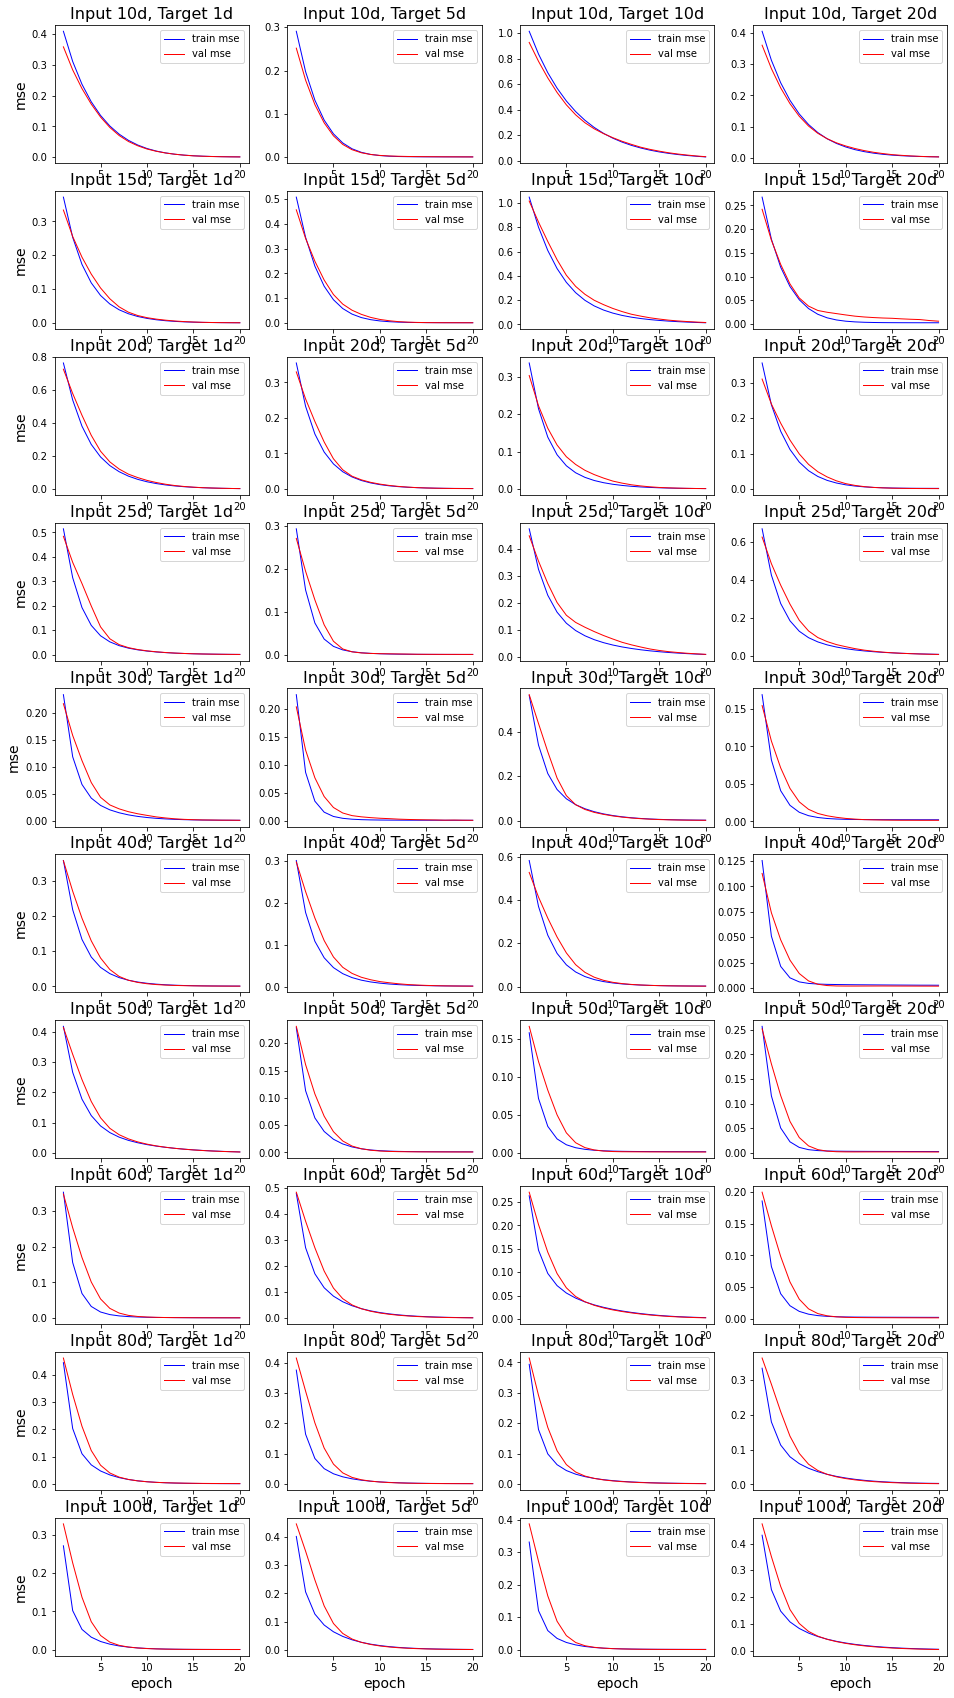

In [15]:
## Plot histories: Mean over number of runs

# mse
fig, axes = plt.subplots(len(input_lengths), len(target_horizons), figsize=(16, 30))
for i in range(len(target_horizons)):
    axes[len(input_lengths)-1,i].set_xlabel("epoch", fontsize=14)
    for j in range(len(input_lengths)):
        axes[j,0].set_ylabel("mse", fontsize=14)
        axes[j,i].plot(np.arange(n_epochs)+1, mean_train_mse[i,j,:], label='train mse', color='blue', linewidth=1)
        axes[j,i].plot(np.arange(n_epochs)+1, mean_val_mse[i,j,:], label='val mse', color='red', linewidth=1)
        axes[j,i].set_title("Input "+str(input_lengths[j])+"d, Target "+target_horizons_text[i], fontsize=16)
        axes[j,i].legend()
        

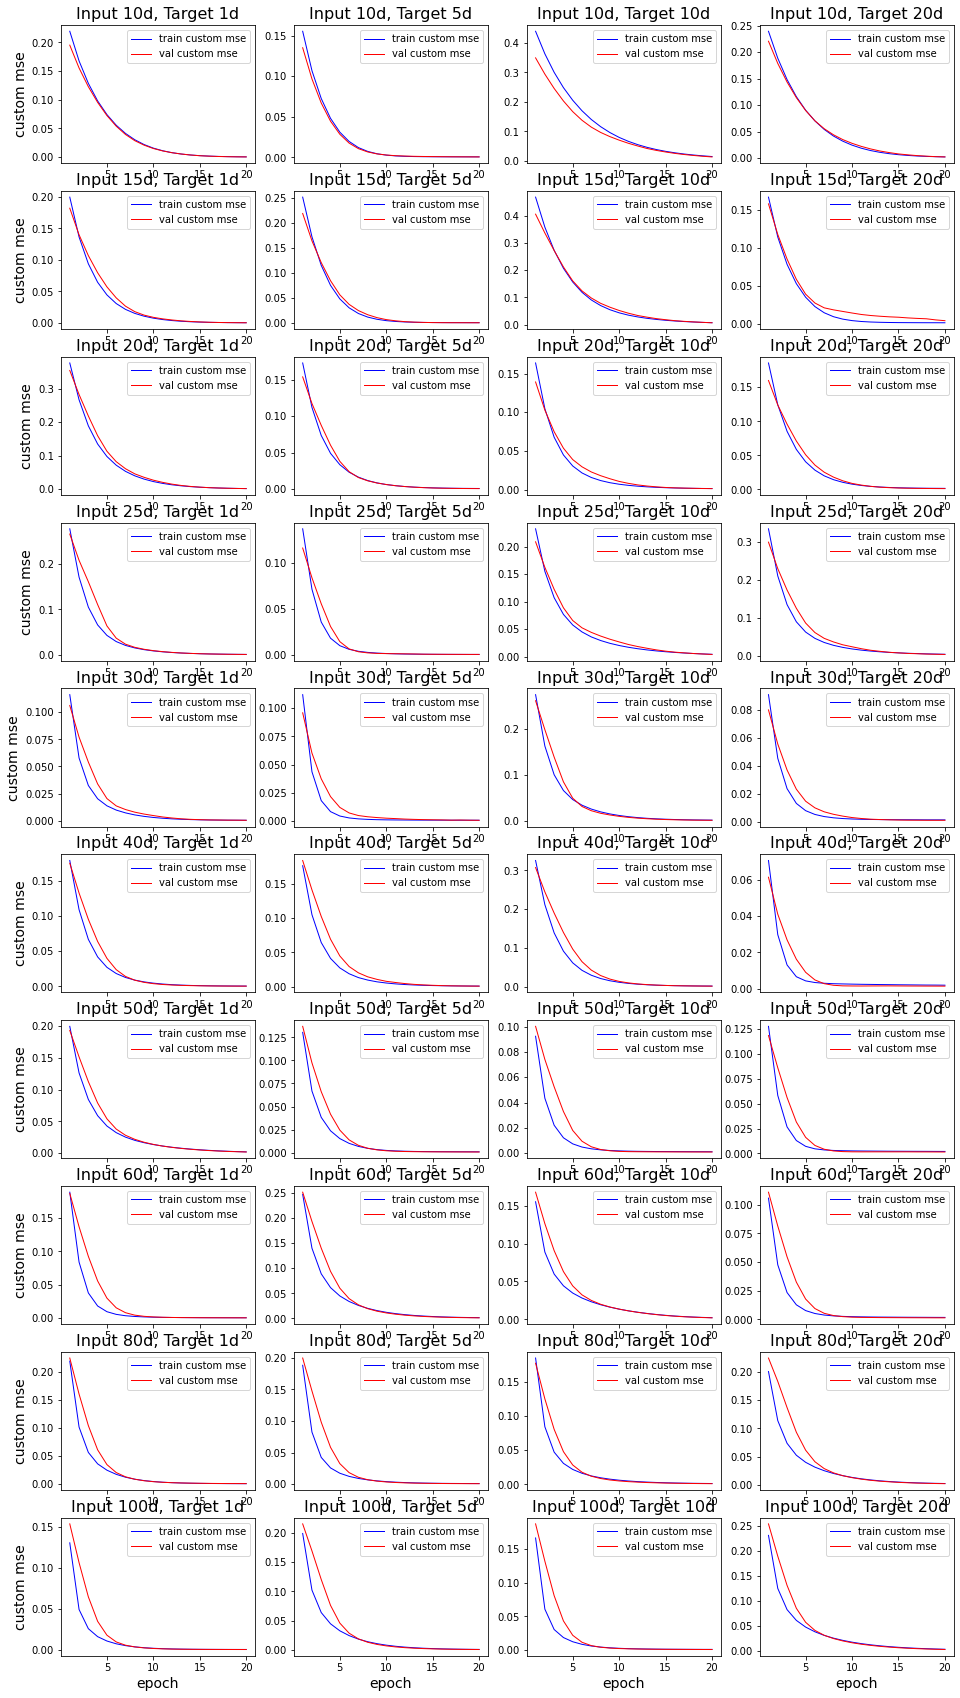

In [34]:
# custom mse
fig, axes = plt.subplots(len(input_lengths), len(target_horizons), figsize=(16, 30))
for i in range(len(target_horizons)):
    axes[len(input_lengths)-1,i].set_xlabel("epoch", fontsize=14)
    for j in range(len(input_lengths)):
        axes[j,0].set_ylabel("custom mse", fontsize=14)
        axes[j,i].plot(np.arange(n_epochs)+1, mean_train_custom_mse[i,j,:], label='train custom mse', color='blue', linewidth=1)
        axes[j,i].plot(np.arange(n_epochs)+1, mean_val_custom_mse[i,j,:], label='val custom mse', color='red', linewidth=1)
        axes[j,i].set_title("Input "+str(input_lengths[j])+"d, Target "+target_horizons_text[i], fontsize=16)
        axes[j,i].legend()

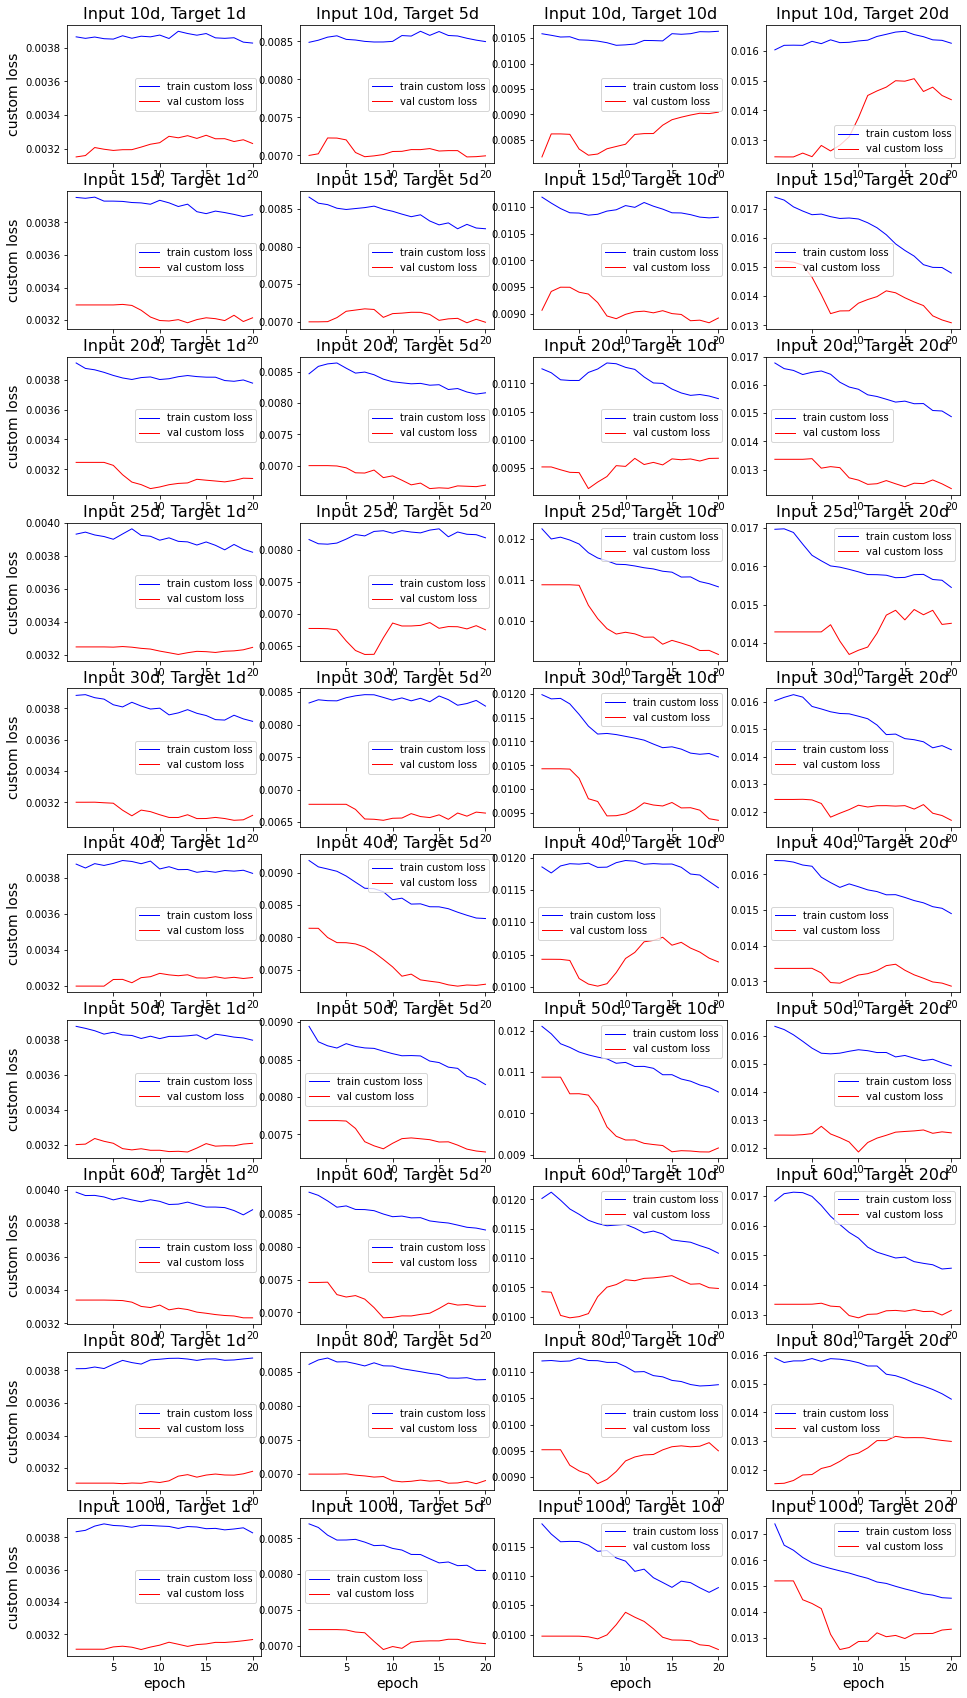

In [35]:
# custom loss
fig, axes = plt.subplots(len(input_lengths), len(target_horizons), figsize=(16, 30))
for i in range(len(target_horizons)):
    axes[len(input_lengths)-1,i].set_xlabel("epoch", fontsize=14)
    for j in range(len(input_lengths)):
        axes[j,0].set_ylabel("custom loss", fontsize=14)
        axes[j,i].plot(np.arange(n_epochs)+1, mean_train_custom_loss[i,j,:], label='train custom loss', color='blue', linewidth=1)
        axes[j,i].plot(np.arange(n_epochs)+1, mean_val_custom_loss[i,j,:], label='val custom loss', color='red', linewidth=1)
        axes[j,i].set_title("Input "+str(input_lengths[j])+"d, Target "+target_horizons_text[i], fontsize=16)
        axes[j,i].legend()

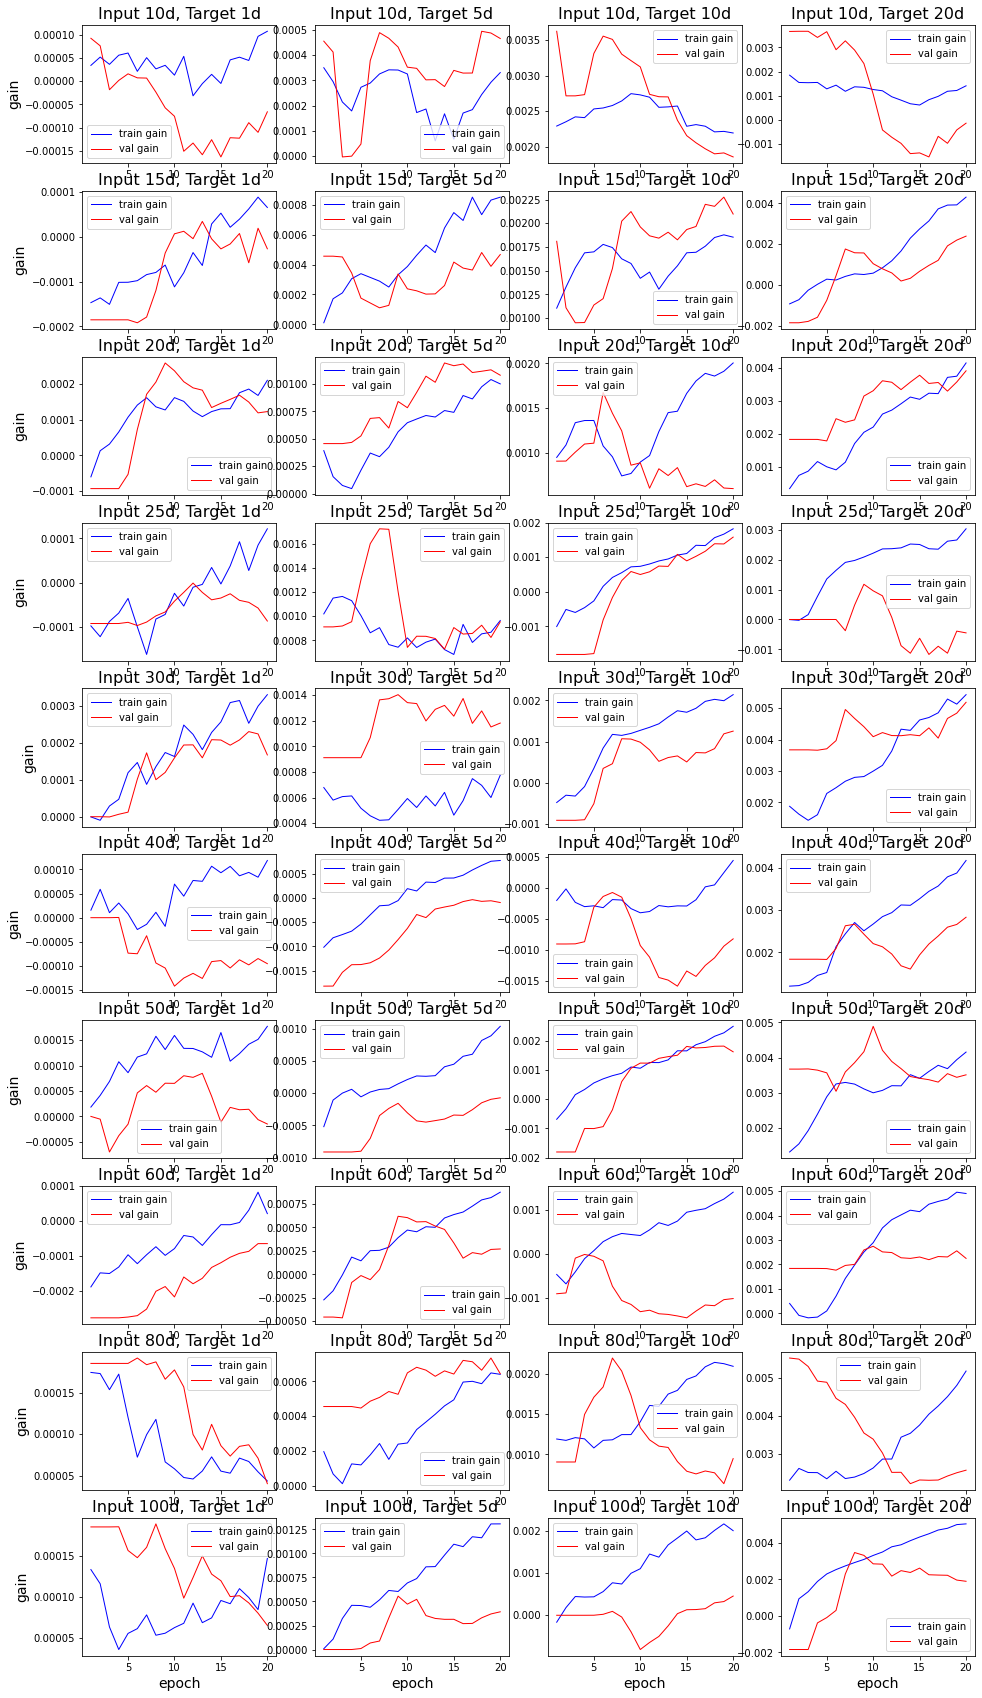

In [36]:
# gain
fig, axes = plt.subplots(len(input_lengths), len(target_horizons), figsize=(16, 30))
for i in range(len(target_horizons)):
    axes[len(input_lengths)-1,i].set_xlabel("epoch", fontsize=14)
    for j in range(len(input_lengths)):
        axes[j,0].set_ylabel("gain", fontsize=14)
        axes[j,i].plot(np.arange(n_epochs)+1, mean_train_gain[i,j,:], label='train gain', color='blue', linewidth=1)
        axes[j,i].plot(np.arange(n_epochs)+1, mean_val_gain[i,j,:], label='val gain', color='red', linewidth=1)
        axes[j,i].set_title("Input "+str(input_lengths[j])+"d, Target "+target_horizons_text[i], fontsize=16)
        axes[j,i].legend()

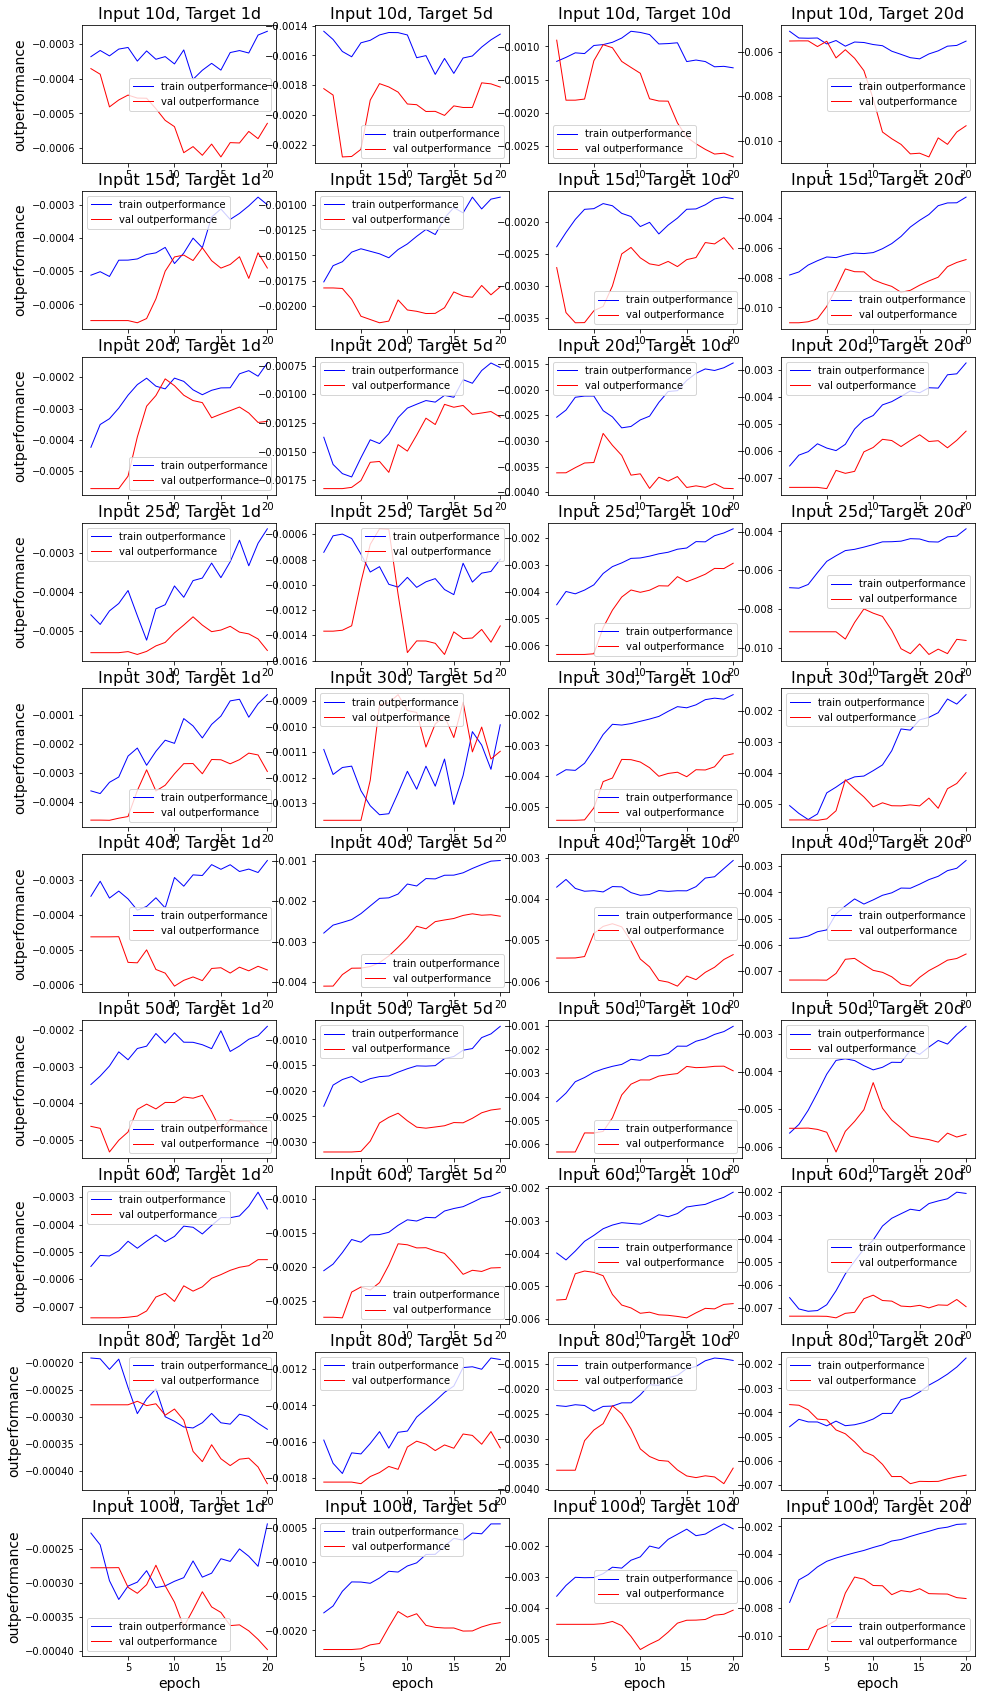

In [37]:
# outperformance
fig, axes = plt.subplots(len(input_lengths), len(target_horizons), figsize=(16, 30))
for i in range(len(target_horizons)):
    axes[len(input_lengths)-1,i].set_xlabel("epoch", fontsize=14)
    for j in range(len(input_lengths)):
        axes[j,0].set_ylabel("outperformance", fontsize=14)
        axes[j,i].plot(np.arange(n_epochs)+1, mean_train_outperformance[i,j,:], label='train outperformance', color='blue', linewidth=1)
        axes[j,i].plot(np.arange(n_epochs)+1, mean_val_outperformance[i,j,:], label='val outperformance', color='red', linewidth=1)
        axes[j,i].set_title("Input "+str(input_lengths[j])+"d, Target "+target_horizons_text[i], fontsize=16)
        axes[j,i].legend()

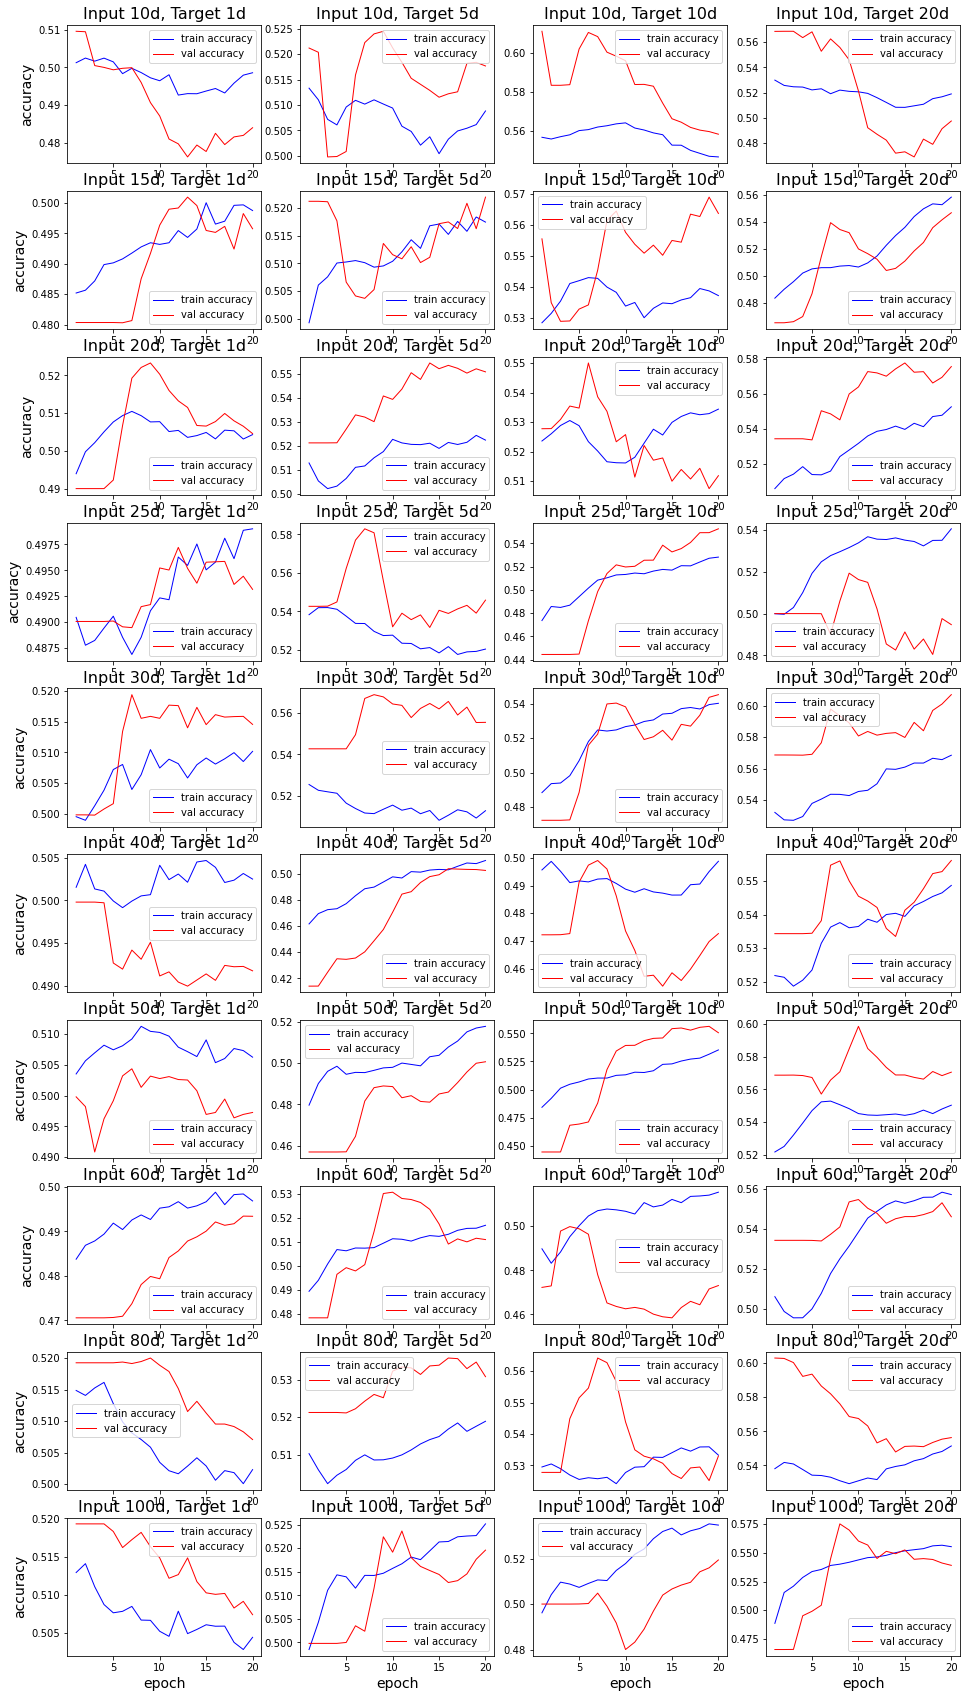

In [38]:
# accuracy
fig, axes = plt.subplots(len(input_lengths), len(target_horizons), figsize=(16, 30))
for i in range(len(target_horizons)):
    axes[len(input_lengths)-1,i].set_xlabel("epoch", fontsize=14)
    for j in range(len(input_lengths)):
        axes[j,0].set_ylabel("accuracy", fontsize=14)
        axes[j,i].plot(np.arange(n_epochs)+1, mean_train_accuracy[i,j,:], label='train accuracy', color='blue', linewidth=1)
        axes[j,i].plot(np.arange(n_epochs)+1, mean_val_accuracy[i,j,:], label='val accuracy', color='red', linewidth=1)
        axes[j,i].set_title("Input "+str(input_lengths[j])+"d, Target "+target_horizons_text[i], fontsize=16)
        axes[j,i].legend()

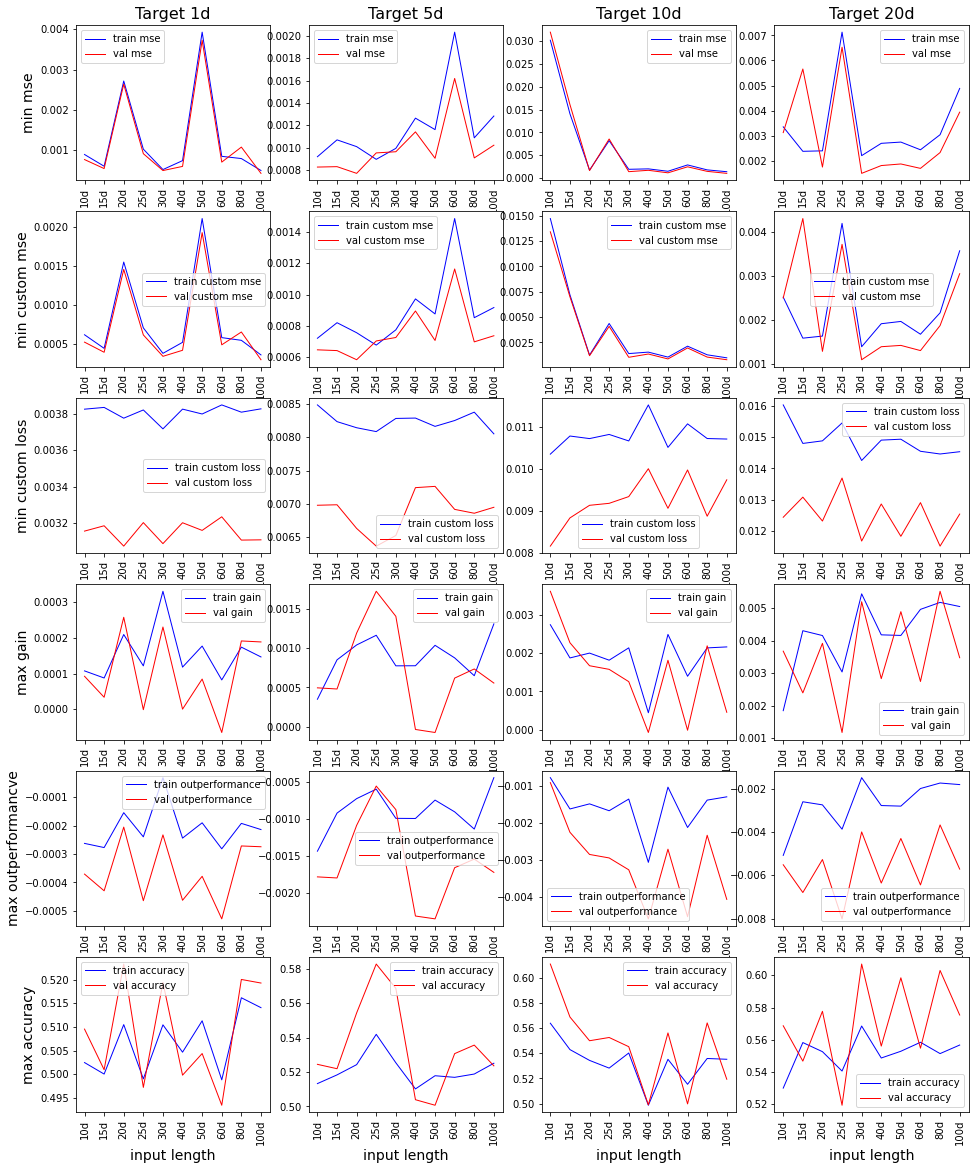

In [45]:
## Plot minimum or maximum (from number of epochs) of mean metrics over input length:

fig, axes = plt.subplots(6, len(target_horizons), figsize=(16, 20))
for i in range(len(target_horizons)):
    
    # min mse
    axes[0,0].set_ylabel("min mse", fontsize=14)
    axes[0,i].plot(np.arange(len(input_lengths))+1, min_train_mse[i,:], label='train mse', color='blue', linewidth=1)
    axes[0,i].plot(np.arange(len(input_lengths))+1, min_val_mse[i,:], label='val mse', color='red', linewidth=1)
    axes[0,i].set_xticks(np.arange(len(input_lengths))+1, input_lengths_text, rotation=90)
    axes[0,i].set_title("Target "+target_horizons_text[i], fontsize=16)
    axes[0,i].legend()
    
    # min custom mse
    axes[1,0].set_ylabel("min custom mse", fontsize=14)
    axes[1,i].plot(np.arange(len(input_lengths))+1, min_train_custom_mse[i,:], label='train custom mse', color='blue', linewidth=1)
    axes[1,i].plot(np.arange(len(input_lengths))+1, min_val_custom_mse[i,:], label='val custom mse', color='red', linewidth=1)
    axes[1,i].set_xticks(np.arange(len(input_lengths))+1, input_lengths_text, rotation=90)
    axes[1,i].legend()
    
    # min custom loss
    axes[2,0].set_ylabel("min custom loss", fontsize=14)
    axes[2,i].plot(np.arange(len(input_lengths))+1, min_train_custom_loss[i,:], label='train custom loss', color='blue', linewidth=1)
    axes[2,i].plot(np.arange(len(input_lengths))+1, min_val_custom_loss[i,:], label='val custom loss', color='red', linewidth=1)
    axes[2,i].set_xticks(np.arange(len(input_lengths))+1, input_lengths_text, rotation=90)
    axes[2,i].legend()
    
    # max gain
    axes[3,0].set_ylabel("max gain", fontsize=14)
    axes[3,i].plot(np.arange(len(input_lengths))+1, max_train_gain[i,:], label='train gain', color='blue', linewidth=1)
    axes[3,i].plot(np.arange(len(input_lengths))+1, max_val_gain[i,:], label='val gain', color='red', linewidth=1)
    axes[3,i].set_xticks(np.arange(len(input_lengths))+1, input_lengths_text, rotation=90)
    axes[3,i].legend()

    # max outperformance
    axes[4,0].set_ylabel("max outperformancve", fontsize=14)
    axes[4,i].plot(np.arange(len(input_lengths))+1, max_train_outperformance[i,:], label='train outperformance', color='blue', linewidth=1)
    axes[4,i].plot(np.arange(len(input_lengths))+1, max_val_outperformance[i,:], label='val outperformance', color='red', linewidth=1)
    axes[4,i].set_xticks(np.arange(len(input_lengths))+1, input_lengths_text, rotation=90)
    axes[4,i].legend()
    
    # max accuracy
    axes[5,0].set_ylabel("max accuracy", fontsize=14)
    axes[5,i].plot(np.arange(len(input_lengths))+1, max_train_accuracy[i,:], label='train accuracy', color='blue', linewidth=1)
    axes[5,i].plot(np.arange(len(input_lengths))+1, max_val_accuracy[i,:], label='val accuracy', color='red', linewidth=1)
    axes[5,i].set_xticks(np.arange(len(input_lengths))+1, input_lengths_text, rotation=90)
    axes[5,i].legend()   
    axes[5,i].set_xlabel("input length", fontsize=14)

### CNN/fc model: Discussion of first multi-run experiment

#### Setup

Fixed base parameters as follows:

- weight_init = tfi.glorot_uniform()
- bias_init = tfi.Zeros()
- CNN_filters = [10,20]
- CNN_kernel_sizes = [5,5]
- fc_units = [20,10]
- n_epochs = 20
- batch_size = 100
- learning_rate = 0.0001
- loss_function = 'mse'

Performed multi-run experiment with **n_runs = 10**. Look for **optimal input length** from [10, 15, 20, 25, 30, 40, 50, 60, 80, 100] **for all target length** 1d/5d/10d/20d seperately. Used **close_rel_chg** as **only input feature** for now and regular **mse loss**.

**SAVED RESULTS:** histories_multirun_01.npy

#### Discussion

We only get poor results from this setup with only one input feature. It's hard to chose the **optimal input length** from these results.

- Stick to **input_length = 20d** for now and postpone optimizing further parameters, e.g. model architecture (number of CNN/fc layers and units), batch_size, learning_rate, ...
- And also postpone trying different loss function (e.g. custom mse) during training process.

Instead **pick some quasi-optimal parameter set** and perform **multiple runs**. Keep track of **where binary predictions equal binary targets**. Do we find spots or sectors ("regimes") with **high / low accuracy**. Or is that just random?

### CNN/fc model: Second multi-run experiment on fixed parameter set to find high/low reliability sectors

Fix base parameters as follows:

- weight_init = tfi.glorot_uniform()
- bias_init = tfi.Zeros()
- CNN_filters = [10,20]
- CNN_kernel_sizes = [5,5]
- fc_units = [20,10]
- n_epochs = 20
- batch_size = 100
- learning_rate = 0.0001
- loss_function = 'mse'

Perform multi-run experiment with **n_runs = 11** (to have an uneven number!). Assume **optimal input length** to be **20d**. Do the experiment **for all target length** 1d/5d/10d/20d seperately. Use **close_rel_chg** as **only input feature** for now and regular **mse loss**.

**SAVED RESULTS:** Where binary predictions on train, validation and test data meet binary targets

- histories_multirun_02a.npy --> train_correct_pred
- histories_multirun_02b.npy --> val_correct_pred
- histories_multirun_02c.npy --> test_correct_pred

#### Idea of this experiment:

- We already know from previous experiments, that we end up with poor accuracy, close to random guessing. At least on average over **all** samples. But now we want to investigate, if we find sectors or phases where our models perform better or worse than average, **just locally**. 
- We therefore do a multirun experiment with an uneven number of runs - in our case **n_runs = 11**. 
- And then we look for samples, where the majority of runs come to the correct (binary) prediction - in terms of correctly prediction UP/DOWN movements.
- This can then be visualized by **shading areas green** (the majority of models gets correct prediction) **and red** (majority of models fail).

In [8]:
## Set parameters:

# Number of runs for each setting:
n_runs = 11

# Fixed model parameters:
weight_init = tfi.glorot_uniform() # Taken as default.
bias_init = tfi.Zeros() # Taken as default.
CNN_filters = [10,20]
CNN_kernel_sizes = [5,5]
fc_units = [20,10]
n_epochs = 20
batch_size = 100
learning_rate = 0.0001
loss_function = 'mse' # String ('mse', 'custom_mse' or 'custom_loss') to choose the loss function.

In [10]:
# Parameters to be chosen for pre-processing:
input_features = (0,) # 0: close (rel. chg.), 1: volume (rel. chg.), 2: range (rel.)
target_horizons = [(0,), (1,), (2,), (3,),] # 0: 1d, 1: 5d, 2: 10d, 3: 20d
input_length = 20

# For plotting: Declare target_horizons as real text:
target_horizons_text = ["1d", "5d", "10d", "20d"]

In [10]:
## Pre-process inputs and targets for first target horizon already.
## That's necessary to have the correct dimensions for storing model predictions later on.

# Select specified input features:
inputs_selected = inputs[:,input_features]

# Select target horizon:
target_selected = targets[:, target_horizons[0]]

# Split input values into sequences of specified input length:
inputs_split = split_sequence(inputs_selected, input_length)

# Adjust data, year and targets: Cut first (input_length - 1) entries
data_cut = data[input_length-1:]
year_cut = year[input_length-1:]
target_cut = target_selected[input_length-1:]

## Split inputs and targets into train / validation / test sets, according to year:

# Train data: 1985 .. 2009
# Val data:   2010 .. 2019
# Test data:  2020 .. end

train_input = inputs_split[year_cut <= 2009]
val_input = inputs_split[(year_cut >= 2010) & (year_cut < 2020)]
test_input = inputs_split[year_cut >= 2020]

train_target = target_cut[year_cut <= 2009]
val_target = target_cut[(year_cut >= 2010) & (year_cut < 2020)]
test_target = target_cut[year_cut >= 2020]

# Convert to binary targets (up = 1, down = 0):
train_target_bin = train_target>0
val_target_bin = val_target>0
test_target_bin = test_target>0

In [11]:
# Initialize storage for predictions and correct predictions for ALL target horizons.
# Desired shape: (#target horizons, #runs, #samples)
train_pred_all = np.zeros((len(target_horizons), n_runs, len(train_target)))
val_pred_all = np.zeros((len(target_horizons), n_runs, len(val_target)))
test_pred_all = np.zeros((len(target_horizons), n_runs, len(test_target)))
train_correct_pred = np.zeros((len(target_horizons), n_runs, len(train_target)))
val_correct_pred = np.zeros((len(target_horizons), n_runs, len(val_target)))
test_correct_pred = np.zeros((len(target_horizons), n_runs, len(test_target)))

In [12]:
# Loop over target horizons:
for i in range(len(target_horizons)):
    
    # Get current target horizon:
    target_horizon = target_horizons[i]
    
    # Print status:
    print("Target horizon: ", i+1, " of ", len(target_horizons))
            
    ## Pre-process inputs and targets: (Note: For first tareget_horizon this step is redundant.)

    # Select specified input features:
    inputs_selected = inputs[:,input_features]

    # Select target horizon:
    target_selected = targets[:, target_horizon]

    # Split input values into sequences of specified input length:
    inputs_split = split_sequence(inputs_selected, input_length)

    # Adjust data, year and targets: Cut first (input_length - 1) entries
    data_cut = data[input_length-1:]
    year_cut = year[input_length-1:]
    target_cut = target_selected[input_length-1:]

    ## Split inputs and targets into train / validation / test sets, according to year:

    # Train data: 1985 .. 2009
    # Val data:   2010 .. 2019
    # Test data:  2020 .. end

    train_input = inputs_split[year_cut <= 2009]
    val_input = inputs_split[(year_cut >= 2010) & (year_cut < 2020)]
    test_input = inputs_split[year_cut >= 2020]

    train_target = target_cut[year_cut <= 2009]
    val_target = target_cut[(year_cut >= 2010) & (year_cut < 2020)]
    test_target = target_cut[year_cut >= 2020]

    # Convert to binary targets (up = 1, down = 0):
    train_target_bin = train_target>0
    val_target_bin = val_target>0
    test_target_bin = test_target>0

    # Get min and max for ALL input features from TRAIN data:
    train_min = np.min(train_input, axis=(0,1))
    train_max = np.max(train_input, axis=(0,1))

    # Apply min max scaling to train / val / test inputs: Substract min and divide by (max - min)
    train_input_scaled = (train_input - train_min) / (train_max - train_min)
    val_input_scaled = (val_input - train_min) / (train_max - train_min)
    test_input_scaled = (test_input - train_min) / (train_max - train_min)
    
    # Loop over number of runs:
    for n_run in range(n_runs):

        # Print status:
        print("  Run: ", n_run+1, " of ", n_runs)

        # Set up compiled model:
        model = set_CNN_fc(
            CNN_filters, CNN_kernel_sizes, fc_units, n_epochs, batch_size, learning_rate, loss_function
        )

        # Train model on scaled inputs and un-scaled targets:
        history = model.fit(
            train_input_scaled, train_target,
            epochs=n_epochs, batch_size=batch_size, 
            shuffle=True, verbose=0, 
            validation_data=(val_input_scaled, val_target)
        )

        # Get model predictions:
        train_pred = model.predict(train_input_scaled)
        val_pred = model.predict(val_input_scaled)
        test_pred = model.predict(test_input_scaled)
        
        # Convert to binary predictions (up = 1, down = 0):
        train_pred_bin = (train_pred > 0)
        val_pred_bin = (val_pred > 0)
        test_pred_bin = (test_pred > 0)
        
        # Store model predictions on train, validation and test data
        train_pred_all[i,n_run,:] = train_pred[:,0]
        val_pred_all[i,n_run,:] = val_pred[:,0]
        test_pred_all[i,n_run,:] = test_pred[:,0]  
        
        # Store for current run where binary predictions on train, validation and test data meet binary targets:
        train_correct_pred[i,n_run,:] = ((train_pred_bin == train_target_bin).astype(int)[:,0])
        val_correct_pred[i,n_run,:] = (val_pred_bin == val_target_bin).astype(int)[:,0]
        test_correct_pred[i,n_run,:] = (test_pred_bin == test_target_bin).astype(int)[:,0]

Target horizon:  1  of  4
  Run:  1  of  11


2022-08-30 07:39:52.946737: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-30 07:39:53.054923: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


  Run:  2  of  11
  Run:  3  of  11
  Run:  4  of  11
  Run:  5  of  11
  Run:  6  of  11
  Run:  7  of  11
  Run:  8  of  11
  Run:  9  of  11
  Run:  10  of  11
  Run:  11  of  11
Target horizon:  2  of  4
  Run:  1  of  11
  Run:  2  of  11
  Run:  3  of  11
  Run:  4  of  11
  Run:  5  of  11
  Run:  6  of  11
  Run:  7  of  11
  Run:  8  of  11
  Run:  9  of  11
  Run:  10  of  11
  Run:  11  of  11
Target horizon:  3  of  4
  Run:  1  of  11
  Run:  2  of  11
  Run:  3  of  11
  Run:  4  of  11
  Run:  5  of  11
  Run:  6  of  11
  Run:  7  of  11
  Run:  8  of  11
  Run:  9  of  11
  Run:  10  of  11
  Run:  11  of  11
Target horizon:  4  of  4
  Run:  1  of  11
  Run:  2  of  11
  Run:  3  of  11
  Run:  4  of  11
  Run:  5  of  11
  Run:  6  of  11
  Run:  7  of  11
  Run:  8  of  11
  Run:  9  of  11
  Run:  10  of  11
  Run:  11  of  11


In [17]:
## Save and reload histories:

# np.save('../results/histories_multirun_02a.npy', train_correct_pred)
# np.save('../results/histories_multirun_02b.npy', val_correct_pred)
# np.save('../results/histories_multirun_02c.npy', test_correct_pred)

# train_correct_pred = np.load('../results/histories_multirun_02a.npy')
# val_correct_pred = np.load('../results/histories_multirun_02b.npy')
# test_correct_pred = np.load('../results/histories_multirun_02c.npy')

## Additional parameters to restore plots subsequent steps from re-loaded data:
# target_horizons = [(0,), (1,), (2,), (3,),] # 0: 1d, 1: 5d, 2: 10d, 3: 20d
# input_length = 20
# target_horizons_text = ["1d", "5d", "10d", "20d"]
# n_epochs = 20

In [14]:
## Post-Processing: Count correct predictions over number of runs.
sum_train_correct_pred = np.sum(train_correct_pred, axis=1)
sum_val_correct_pred = np.sum(val_correct_pred, axis=1)
sum_test_correct_pred = np.sum(test_correct_pred, axis=1)

## Get absolute closing price from cut data by splitting according to year:

# Train data: 1985 .. 2009
# Val data:   2010 .. 2019
# Test data:  2020 .. end

train_close_abs = data_cut[year_cut <= 2009][:,4]
val_close_abs = data_cut[(year_cut >= 2010) & (year_cut < 2020)][:,4]
test_close_abs = data_cut[year_cut >= 2020][:,4]

# # Check dimensions:
print("sum_train_correct_pred shape: (#target horizons, samples)", sum_train_correct_pred.shape)
print("sum_val_correct_pred shape: (#target horizons, samples)", sum_val_correct_pred.shape)
print("sum_test_correct_pred shape: (#target horizons, samples)", sum_test_correct_pred.shape)
print("train_close_abs shape (samples, time steps, features): ", train_close_abs.shape)
print("val_close_abs shape (samples, time steps, features): ", val_close_abs.shape)
print("test_close_abs shape (samples, time steps, features): ", test_close_abs.shape)

sum_train_correct_pred shape: (#target horizons, samples) (4, 6284)
sum_val_correct_pred shape: (#target horizons, samples) (4, 2516)
sum_test_correct_pred shape: (#target horizons, samples) (4, 587)
train_close_abs shape (samples, time steps, features):  (6284,)
val_close_abs shape (samples, time steps, features):  (2516,)
test_close_abs shape (samples, time steps, features):  (587,)


In [15]:
## Get min/max from absolute closing prices for train, val and test data.
## Convert to constant lines for plotting later on: Need min / max lines as limits.
train_close_abs_min = np.min(train_close_abs) * np.ones(len(train_close_abs))
train_close_abs_max = np.max(train_close_abs) * np.ones(len(train_close_abs))
val_close_abs_min = np.min(val_close_abs) * np.ones(len(val_close_abs))
val_close_abs_max = np.max(val_close_abs) * np.ones(len(val_close_abs))
test_close_abs_min = np.min(test_close_abs) * np.ones(len(test_close_abs))
test_close_abs_max = np.max(test_close_abs) * np.ones(len(test_close_abs))

Text(0.5, 0, 'time step')

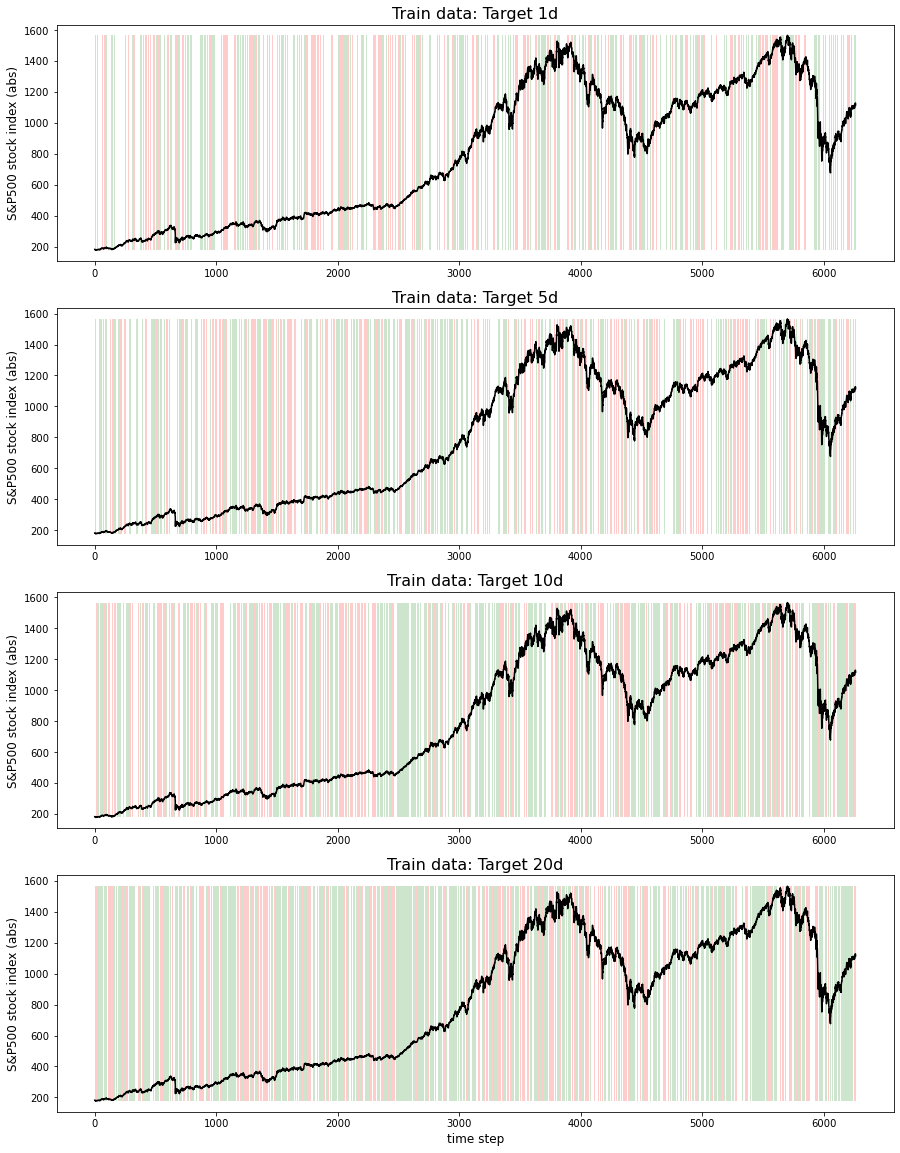

In [18]:
## Plot areas with high / low reliability from multirun experiment:
## Where does the majority of models meet true (green) target or fail (red)?

## NOTE: We did this experiment with fixed input_length = 20d. Therefore need to cut the first 20 steps from 
##       train_close_abs and the last 20 steps from predictions, to adjust time line.

## AND NOTE: We find white areas whenever true and false predictions alternate from step to step.
##           Shaded areas need at least two subsequent true or false predictions.
##           Could alter the plot by setting option "interpolate = True" in fill_between.

# Train data:
fig, axes = plt.subplots(4, 1, figsize=(15,20))

# Loop over target horizons:
for i in range(len(target_horizons)):
    axes[i].plot(train_close_abs[20:], color = 'black', label = 'val close (abs)')
    axes[i].set_ylabel("S&P500 stock index (abs)", fontsize=12)
    axes[i].set_title("Train data: Target " + target_horizons_text[i], fontsize=16)

    # Shade area highlighting distinct periods.
    axes[i].fill_between(range(len(train_close_abs[20:])),train_close_abs_min[:-20], train_close_abs_max[:-20], 
                         where = (sum_train_correct_pred[i,:-20] >= 6), facecolor='green', alpha=0.2)
    axes[i].fill_between(range(len(train_close_abs[20:])),train_close_abs_min[:-20], train_close_abs_max[:-20], 
                         where = (sum_train_correct_pred[i,:-20] < 6), facecolor='red', alpha=0.2)
    
axes[3].set_xlabel("time step", fontsize=12)



Text(0.5, 0, 'time step')

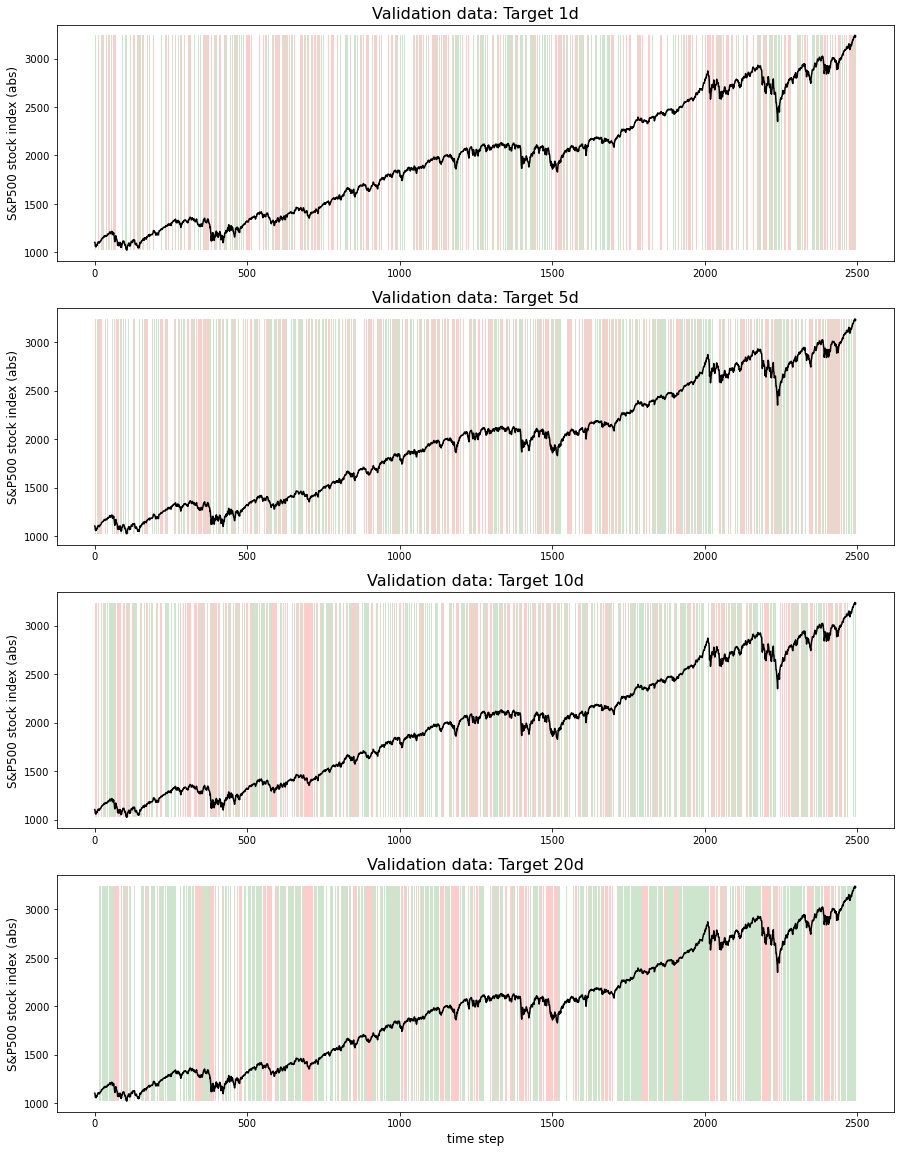

In [173]:
# Validation data:
fig, axes = plt.subplots(4, 1, figsize=(15,20))

# Loop over target horizons:
for i in range(len(target_horizons)):
    axes[i].plot(val_close_abs[20:], color = 'black', label = 'val close (abs)')
    axes[i].set_ylabel("S&P500 stock index (abs)", fontsize=12)
    axes[i].set_title("Validation data: Target " + target_horizons_text[i], fontsize=16)

    # Shade area highlighting distinct periods.
    axes[i].fill_between(range(len(val_close_abs[20:])),val_close_abs_min[:-20], val_close_abs_max[:-20], 
                         where = (sum_val_correct_pred[i,:-20] >= 6), facecolor='green', alpha=0.2)
    axes[i].fill_between(range(len(val_close_abs[20:])),val_close_abs_min[:-20], val_close_abs_max[:-20], 
                         where = (sum_val_correct_pred[i,:-20] < 6), facecolor='red', alpha=0.2)
    
axes[3].set_xlabel("time step", fontsize=12)

Text(0.5, 0, 'time step')

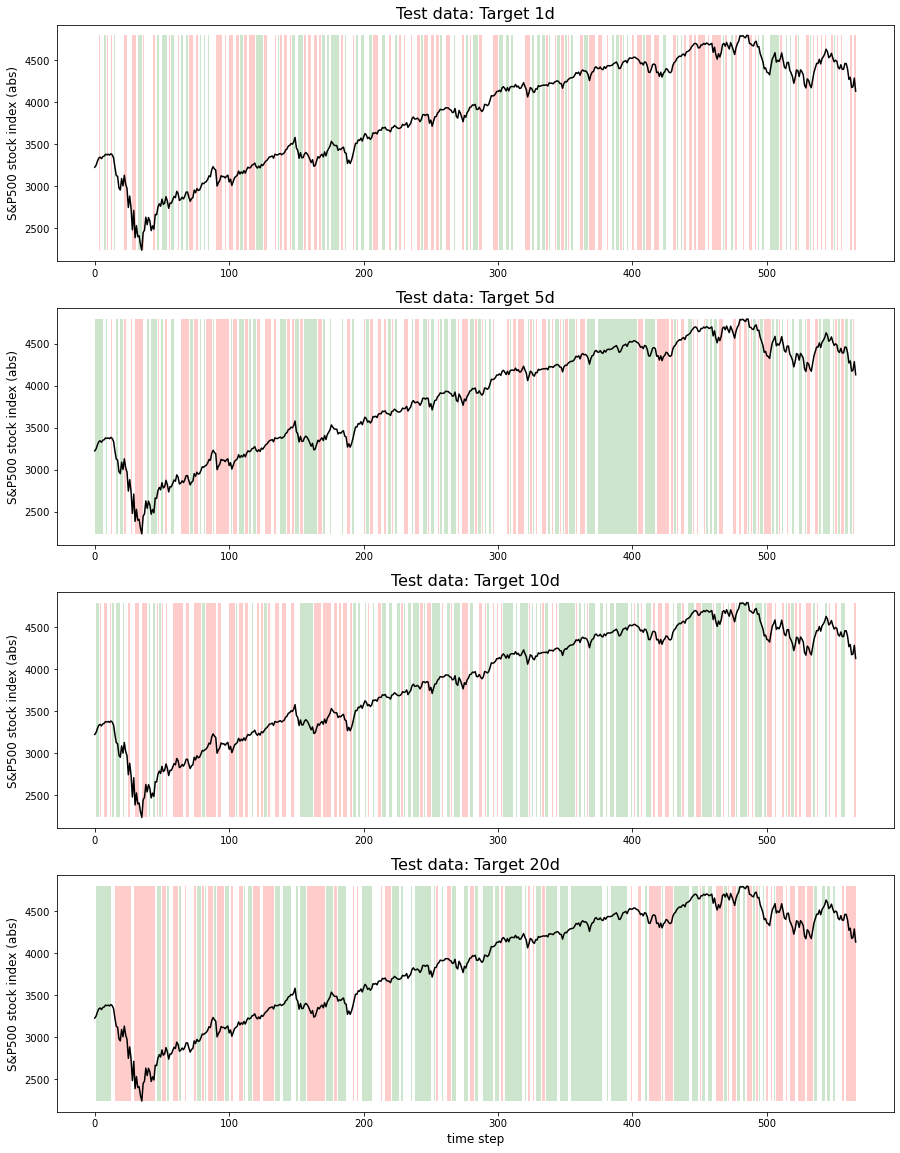

In [175]:
# Test data:
fig, axes = plt.subplots(4, 1, figsize=(15,20))

# Loop over target horizons:
for i in range(len(target_horizons)):
    axes[i].plot(test_close_abs[20:], color = 'black', label = 'val close (abs)')
    axes[i].set_ylabel("S&P500 stock index (abs)", fontsize=12)
    axes[i].set_title("Test data: Target " + target_horizons_text[i], fontsize=16)

    # Shade area highlighting distinct periods.
    axes[i].fill_between(range(len(test_close_abs[20:])),test_close_abs_min[:-20], test_close_abs_max[:-20], 
                         where = (sum_test_correct_pred[i,:-20] >= 6), facecolor='green', alpha=0.2)
    axes[i].fill_between(range(len(test_close_abs[20:])),test_close_abs_min[:-20], test_close_abs_max[:-20], 
                         where = (sum_test_correct_pred[i,:-20] < 6), facecolor='red', alpha=0.2)
    
axes[3].set_xlabel("time step", fontsize=12)

Text(0.5, 0, 'time step')

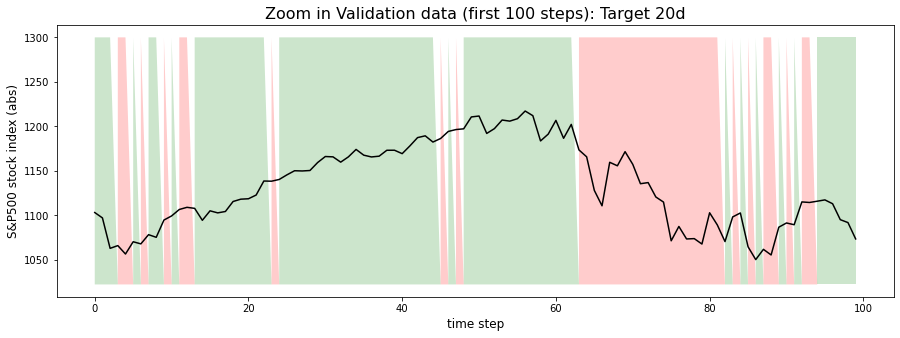

In [176]:
# Validation data:
fig, axes = plt.subplots(1, 1, figsize=(15,5))

# Loop over target horizons:
axes.plot(val_close_abs[20:120], color = 'black', label = 'val close (abs)')
axes.set_ylabel("S&P500 stock index (abs)", fontsize=12)
axes.set_title("Zoom in Validation data (first 100 steps): Target " + target_horizons_text[3], fontsize=16)

# Shade area highlighting distinct periods.
axes.fill_between(range(len(val_close_abs[:100])),val_close_abs_min[:100], 1300, 
                     where = (sum_val_correct_pred[3,:100] >= 6), facecolor='green', alpha=0.2, interpolate=True)
axes.fill_between(range(len(val_close_abs[:100])),val_close_abs_min[:100], 1300, 
                     where = (sum_val_correct_pred[3,:100] < 6), facecolor='red', alpha=0.2, interpolate=True)

axes.set_xlabel("time step", fontsize=12)

### Discussion on second multirun experiment: Finding high / low reliability regimes

We indeed find connected areas of high / low reliability - at least for **target = 20d**. On the first sight it looks like the models tend to fail whenever things get rough and stocks either crash or heavily fluctuate.

If this holds true, the task could be altered or extended to train a separate model that should find **tipping points** or **regime shifts**.

In a simplified way we next try to **train a model on regular scaled inputs (close rel. chg.)** and use the number of correct predictions as **binary target**: 

- 0: If the majority of models from our second multirun experiment meet the true target
- 1: Else

Since we found best connected areas for **target length 20d** by visual inspection, stick to that for now.

In [80]:
## Prepare binary targets:
# Focus on target = 20d.
# Check, where majority of model runs produced CORRECT prediction.
# Reshape to have dimensions (samples, 1).
train_target_true_pred_bin = (sum_train_correct_pred[3,:] >= 6).astype(int).reshape((len(sum_train_correct_pred[3,:]), 1))
val_target_true_pred_bin = (sum_val_correct_pred[3,:] >= 6).astype(int).reshape((len(sum_val_correct_pred[3,:]), 1))
test_target_true_pred_bin = (sum_test_correct_pred[3,:] >= 6).astype(int).reshape((len(sum_test_correct_pred[3,:]), 1))

In [74]:
## Set parameters:

# Number of runs for each setting:
n_runs = 11

# Fixed model parameters:
weight_init = tfi.glorot_uniform() # Taken as default.
bias_init = tfi.Zeros() # Taken as default.
CNN_filters = [10,20]
CNN_kernel_sizes = [5,5]
fc_units = [20,10]
n_epochs = 100
batch_size = 100
learning_rate = 0.0005
loss_function = tf.keras.losses.BinaryCrossentropy(from_logits=False)

# Parameters to be chosen for pre-processing:
input_features = (0,) # 0: close (rel. chg.), 1: volume (rel. chg.), 2: range (rel.)
input_length = 20

In [75]:
## Pre-process inputs and targets for target horizon 20d.

# Select specified input features:
inputs_selected = inputs[:,input_features]

# Select target horizon:
target_selected = targets[:, (3,)]

# Split input values into sequences of specified input length:
inputs_split = split_sequence(inputs_selected, input_length)

# Adjust data, year and targets: Cut first (input_length - 1) entries
data_cut = data[input_length-1:]
year_cut = year[input_length-1:]
target_cut = target_selected[input_length-1:]

## Split inputs and targets into train / validation / test sets, according to year:

# Train data: 1985 .. 2009
# Val data:   2010 .. 2019
# Test data:  2020 .. end

train_input = inputs_split[year_cut <= 2009]
val_input = inputs_split[(year_cut >= 2010) & (year_cut < 2020)]
test_input = inputs_split[year_cut >= 2020]

train_target = target_cut[year_cut <= 2009]
val_target = target_cut[(year_cut >= 2010) & (year_cut < 2020)]
test_target = target_cut[year_cut >= 2020]

# Convert to binary targets (up = 1, down = 0):
train_target_bin = train_target>0
val_target_bin = val_target>0
test_target_bin = test_target>0

# Get min and max for ALL input features from TRAIN data:
train_min = np.min(train_input, axis=(0,1))
train_max = np.max(train_input, axis=(0,1))

# Apply min max scaling to train / val / test inputs: Substract min and divide by (max - min)
train_input_scaled = (train_input - train_min) / (train_max - train_min)
val_input_scaled = (val_input - train_min) / (train_max - train_min)
test_input_scaled = (test_input - train_min) / (train_max - train_min)

In [76]:
## Set up model on binary targets. Use regular scaled inputs (close rel chg) with input length 20d.

# Start model definition:
model = Sequential()

# Add input layer:
input_shape = (input_length, len(input_features))
model.add(Input(shape=input_shape))

# Add CNN layer(s):
for i in range(len(CNN_filters)):
    model.add(Conv1D(filters=CNN_filters[i], kernel_size=CNN_kernel_sizes[i], strides=1,
                     kernel_initializer=weight_init, bias_initializer = bias_init))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.3))

    # Add max pooling, if input_length is equal or above 40d to limit number of trainable parameters:
    if input_length >= 40:
        model.add(MaxPooling1D(pool_size=2))

# Flatten CNN output:
model.add(Flatten())

# Add hidden fc layer(s):
for i in range(len(fc_units)):
    model.add(Dense(units=fc_units[i], activation = 'sigmoid',
                    kernel_initializer=weight_init, bias_initializer = bias_init))

# Add output unit:
model.add(Dense(units=1, name = "output", activation = 'sigmoid',
                kernel_initializer=weight_init, bias_initializer = bias_init))

# Compile model with desired loss function:
model.compile(optimizer=Adam(learning_rate=learning_rate), loss=loss_function, metrics=(['acc']))

In [77]:
# Train model on scaled inputs and binary targets:
history = model.fit(train_input_scaled, train_target_true_pred_bin, epochs=n_epochs, batch_size=batch_size,
                    shuffle=True, verbose=2, validation_data=(val_input_scaled, val_target_true_pred_bin))

Epoch 1/100
63/63 - 1s - loss: 0.7432 - acc: 0.4082 - val_loss: 0.7125 - val_acc: 0.3780
Epoch 2/100
63/63 - 0s - loss: 0.6785 - acc: 0.5998 - val_loss: 0.6748 - val_acc: 0.6220
Epoch 3/100
63/63 - 0s - loss: 0.6717 - acc: 0.6033 - val_loss: 0.6665 - val_acc: 0.6220
Epoch 4/100
63/63 - 0s - loss: 0.6710 - acc: 0.6033 - val_loss: 0.6642 - val_acc: 0.6220
Epoch 5/100
63/63 - 0s - loss: 0.6706 - acc: 0.6033 - val_loss: 0.6628 - val_acc: 0.6220
Epoch 6/100
63/63 - 0s - loss: 0.6704 - acc: 0.6033 - val_loss: 0.6626 - val_acc: 0.6220
Epoch 7/100
63/63 - 0s - loss: 0.6698 - acc: 0.6033 - val_loss: 0.6624 - val_acc: 0.6220
Epoch 8/100
63/63 - 0s - loss: 0.6695 - acc: 0.6036 - val_loss: 0.6623 - val_acc: 0.6220
Epoch 9/100
63/63 - 0s - loss: 0.6692 - acc: 0.6033 - val_loss: 0.6621 - val_acc: 0.6220
Epoch 10/100
63/63 - 0s - loss: 0.6689 - acc: 0.6039 - val_loss: 0.6617 - val_acc: 0.6220
Epoch 11/100
63/63 - 0s - loss: 0.6685 - acc: 0.6036 - val_loss: 0.6617 - val_acc: 0.6220
Epoch 12/100
63/63 

63/63 - 0s - loss: 0.5527 - acc: 0.7196 - val_loss: 1.2433 - val_acc: 0.3990
Epoch 93/100
63/63 - 0s - loss: 0.5488 - acc: 0.7250 - val_loss: 0.7493 - val_acc: 0.5461
Epoch 94/100
63/63 - 0s - loss: 0.5496 - acc: 0.7222 - val_loss: 0.7815 - val_acc: 0.6014
Epoch 95/100
63/63 - 0s - loss: 0.5451 - acc: 0.7320 - val_loss: 0.9186 - val_acc: 0.6208
Epoch 96/100
63/63 - 0s - loss: 0.5416 - acc: 0.7336 - val_loss: 1.0957 - val_acc: 0.4237
Epoch 97/100
63/63 - 0s - loss: 0.5401 - acc: 0.7350 - val_loss: 1.6147 - val_acc: 0.3943
Epoch 98/100
63/63 - 0s - loss: 0.5379 - acc: 0.7357 - val_loss: 0.7878 - val_acc: 0.4992
Epoch 99/100
63/63 - 0s - loss: 0.5351 - acc: 0.7357 - val_loss: 0.9813 - val_acc: 0.4074
Epoch 100/100
63/63 - 0s - loss: 0.5368 - acc: 0.7360 - val_loss: 0.8675 - val_acc: 0.4388


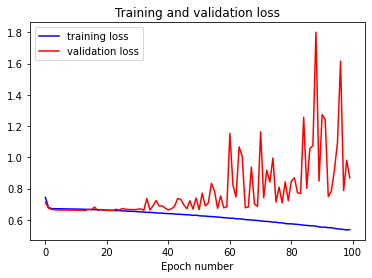

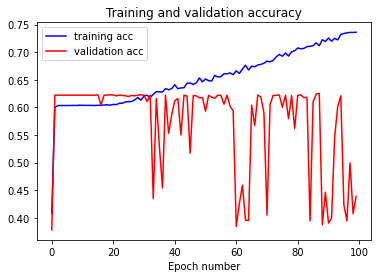

In [78]:
# Plot train and val_loss (bin. cross-entropy)
plt.plot(history.history['loss'], color = 'blue', label = 'training loss')
plt.plot(history.history['val_loss'], color = 'red', label = 'validation loss')
plt.xlabel('Epoch number')
#plt.ylim(0.6, 0.8)
plt.title('Training and validation loss')
plt.legend()
plt.show() 

# Plot train and val_acc
plt.plot(history.history['acc'], color = 'blue', label = 'training acc')
plt.plot(history.history['val_acc'], color = 'red', label = 'validation acc')
plt.xlabel('Epoch number')
#plt.ylim(0.6, 0.8)
plt.title('Training and validation accuracy')
plt.legend()
plt.show() 

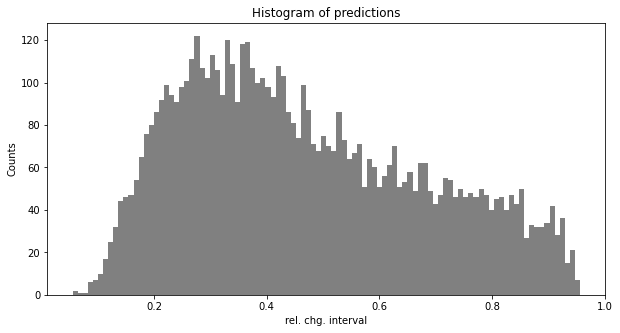

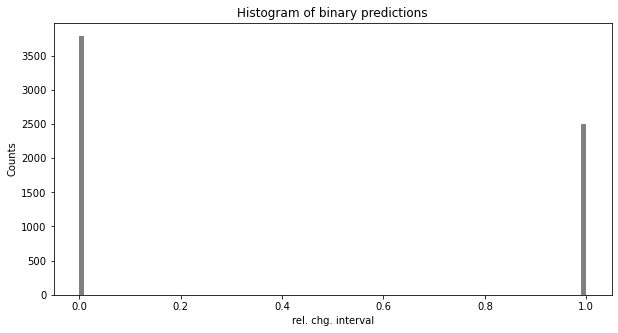

In [79]:
# Get model predictions:
train_pred = model.predict(train_input_scaled)
val_pred = model.predict(val_input_scaled)

# Convert to binary prediction UP (1) / DOWN (0):
train_pred_bin = (train_pred>0.5).astype(int)
val_pred_bin = (val_pred>0.5).astype(int)

# Plot histogram of predictions
nBins = 100
fig, axes = plt.subplots(1, 1, figsize=(10,5))
axes.hist(train_pred[:,0], nBins, color="grey")
axes.set_xlabel("pred. interval")
axes.set_ylabel("Counts")
axes.set_title("Histogram of predictions")
plt.show()

# Plot histogram of predictions - converted to binary predictions: > 0.5 --> UP, <= 0.5 --> DOWN, since we
# use sigmoid activation in final output unit.
nBins = 100
fig, axes = plt.subplots(1, 1, figsize=(10,5))
axes.hist(train_pred_bin[:,0], nBins, color="grey")
axes.set_xlabel("pred. interval")
axes.set_ylabel("Counts")
axes.set_title("Histogram of binary predictions")
plt.show()

In [82]:
# Check naive accuracy on train data:
print("naive train acc: ", np.round(sum(train_target_true_pred_bin)/len(train_target_true_pred_bin),3)[0])
print("naive val acc: ", np.round(sum(val_target_true_pred_bin)/len(val_target_true_pred_bin),3)[0])

naive train acc:  0.603
naive val acc:  0.622


### Discussion on the attempt to train a model to predict high / low reliability areas

We tried to **train a model on regular scaled inputs (close rel. chg.)** and use the number of correct predictions as **binary target**: 

- 0: If the majority of models from our second multirun experiment meet the true target
- 1: Else

Since we found best connected areas for **target length 20d** by visual inspection, we sticked to that target.

The model only reaches naive train and validation accuracies. And if trained over more epochs, it starts to show overfitting tendencies: Train accuracy increases, while validation loss also increases.

### Third multirun experiment: Train model to predict  high / low reliability areas on continuous (discrete) target

Instead of taking binary targets - as described above - we now want to take the sum of correct predictions from second multirun experiment as continuous target (with discrete values).

Again we try to **train a model on regular scaled inputs (close rel. chg.)** and stick to **target length 20d**.

In a multirun experiment with **n_runs = 11** we try to correctly predict high / low reliability areas. We then take the majority vote 
- greater or equal 6 --> "high reliability"
- else --> "low reliability"

and see where predictions meet true high / low reliability areas. Start with **single run** before we perform **multirun** experiment.

In [24]:
## Prepare targets:
# Focus on target = 20d.
# Take sum of correct predictions from second multirun experiment as continuous target (with discrete values).
# Reshape to have dimensions (samples, 1).
train_target_true_pred = sum_train_correct_pred[3,:].reshape((len(sum_train_correct_pred[3,:]), 1))
val_target_true_pred = sum_val_correct_pred[3,:].reshape((len(sum_val_correct_pred[3,:]), 1))
test_target_true_pred = sum_test_correct_pred[3,:].reshape((len(sum_test_correct_pred[3,:]), 1))

In [121]:
## Set parameters:

# Number of runs for each setting:
n_runs = 11

# Fixed model parameters:
weight_init = tfi.glorot_uniform() # Taken as default.
bias_init = tfi.Zeros() # Taken as default.
CNN_filters = [10,20]
CNN_kernel_sizes = [5,5]
fc_units = [20,10]
n_epochs = 15
batch_size = 100
learning_rate = 0.0001
loss_function = 'mse'

# Parameters to be chosen for pre-processing:
input_features = (0,) # 0: close (rel. chg.), 1: volume (rel. chg.), 2: range (rel.)
input_length = 20

In [122]:
## Pre-process inputs and targets for target horizon 20d.

# Select specified input features:
inputs_selected = inputs[:,input_features]

# Select target horizon:
target_selected = targets[:, (3,)]

# Split input values into sequences of specified input length:
inputs_split = split_sequence(inputs_selected, input_length)

# Adjust data, year and targets: Cut first (input_length - 1) entries
data_cut = data[input_length-1:]
year_cut = year[input_length-1:]
target_cut = target_selected[input_length-1:]

## Split inputs and targets into train / validation / test sets, according to year:

# Train data: 1985 .. 2009
# Val data:   2010 .. 2019
# Test data:  2020 .. end

train_input = inputs_split[year_cut <= 2009]
val_input = inputs_split[(year_cut >= 2010) & (year_cut < 2020)]
test_input = inputs_split[year_cut >= 2020]

train_target = target_cut[year_cut <= 2009]
val_target = target_cut[(year_cut >= 2010) & (year_cut < 2020)]
test_target = target_cut[year_cut >= 2020]

# Convert to binary targets (up = 1, down = 0):
train_target_bin = train_target>0
val_target_bin = val_target>0
test_target_bin = test_target>0

# Get min and max for ALL input features from TRAIN data:
train_min = np.min(train_input, axis=(0,1))
train_max = np.max(train_input, axis=(0,1))

# Apply min max scaling to train / val / test inputs: Substract min and divide by (max - min)
train_input_scaled = (train_input - train_min) / (train_max - train_min)
val_input_scaled = (val_input - train_min) / (train_max - train_min)
test_input_scaled = (test_input - train_min) / (train_max - train_min)

In [123]:
## Set up model on continuous (discrete) targets. Use regular scaled inputs (close rel chg) with input length 20d.

# Start model definition:
model = Sequential()

# Add input layer:
input_shape = (input_length, len(input_features))
model.add(Input(shape=input_shape))

# Add CNN layer(s):
for i in range(len(CNN_filters)):
    model.add(Conv1D(filters=CNN_filters[i], kernel_size=CNN_kernel_sizes[i], strides=1,
                     kernel_initializer=weight_init, bias_initializer = bias_init))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.3))

    # Add max pooling, if input_length is equal or above 40d to limit number of trainable parameters:
    if input_length >= 40:
        model.add(MaxPooling1D(pool_size=2))

# Flatten CNN output:
model.add(Flatten())

# Add hidden fc layer(s):
for i in range(len(fc_units)):
    model.add(Dense(units=fc_units[i], activation = 'linear',
                    kernel_initializer=weight_init, bias_initializer = bias_init))

# Add output unit:
model.add(Dense(units=1, name = "output", activation = 'linear',
                kernel_initializer=weight_init, bias_initializer = bias_init))

# Compile model with desired loss function:
model.compile(optimizer=Adam(learning_rate=learning_rate), loss=loss_function)

In [124]:
# Train model on scaled inputs and binary targets:
history = model.fit(train_input_scaled, train_target_true_pred, epochs=n_epochs, batch_size=batch_size,
                    shuffle=True, verbose=2, validation_data=(val_input_scaled, val_target_true_pred))

Epoch 1/15
63/63 - 1s - loss: 33.8770 - val_loss: 39.9674
Epoch 2/15
63/63 - 0s - loss: 19.1369 - val_loss: 36.3019
Epoch 3/15
63/63 - 0s - loss: 10.4657 - val_loss: 24.1389
Epoch 4/15
63/63 - 0s - loss: 6.4596 - val_loss: 8.8845
Epoch 5/15
63/63 - 0s - loss: 5.2858 - val_loss: 4.5499
Epoch 6/15
63/63 - 0s - loss: 5.0107 - val_loss: 5.6480
Epoch 7/15
63/63 - 0s - loss: 4.9478 - val_loss: 6.0184
Epoch 8/15
63/63 - 0s - loss: 4.8204 - val_loss: 5.8859
Epoch 9/15
63/63 - 0s - loss: 4.8832 - val_loss: 5.6446
Epoch 10/15
63/63 - 0s - loss: 4.8410 - val_loss: 4.9245
Epoch 11/15
63/63 - 0s - loss: 4.8000 - val_loss: 4.6875
Epoch 12/15
63/63 - 0s - loss: 4.8059 - val_loss: 4.6574
Epoch 13/15
63/63 - 0s - loss: 4.7580 - val_loss: 4.6739
Epoch 14/15
63/63 - 0s - loss: 4.7425 - val_loss: 5.0668
Epoch 15/15
63/63 - 0s - loss: 4.7114 - val_loss: 4.9972


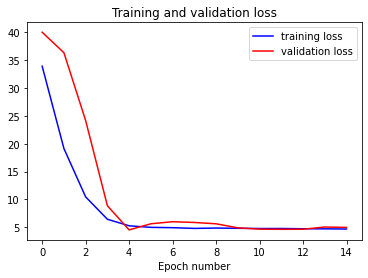

In [125]:
# Plot train and val_loss (mse)
plt.plot(history.history['loss'], color = 'blue', label = 'training loss')
plt.plot(history.history['val_loss'], color = 'red', label = 'validation loss')
plt.xlabel('Epoch number')
#plt.ylim(0.6, 0.8)
plt.title('Training and validation loss')
plt.legend()
plt.show() 

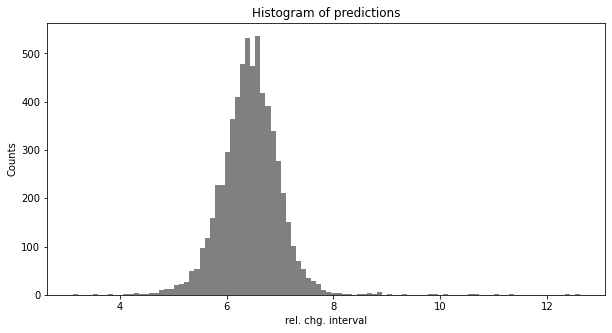

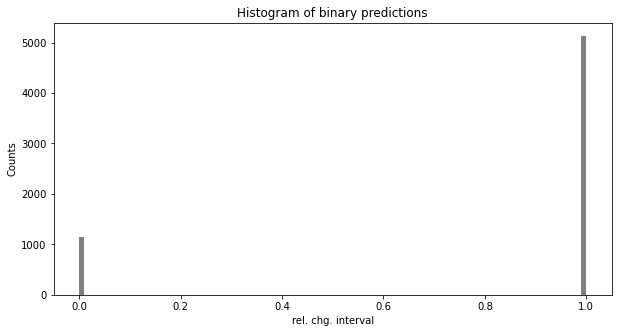

In [126]:
# Get model predictions:
train_pred = model.predict(train_input_scaled)
val_pred = model.predict(val_input_scaled)

# Convert to binary prediction UP (1) / DOWN (0):
train_pred_bin = (train_pred >= 6).astype(int)
val_pred_bin = (val_pred >= 6).astype(int)

# Plot histogram of predictions
nBins = 100
fig, axes = plt.subplots(1, 1, figsize=(10,5))
axes.hist(train_pred[:,0], nBins, color="grey")
axes.set_xlabel("rel. chg. interval")
axes.set_ylabel("Counts")
axes.set_title("Histogram of predictions")
plt.show()

# Plot histogram of predictions - converted to binary predictions: > 0.5 --> UP, <= 0.5 --> DOWN, since we
# use sigmoid activation in final output unit.
nBins = 100
fig, axes = plt.subplots(1, 1, figsize=(10,5))
axes.hist(train_pred_bin[:,0], nBins, color="grey")
axes.set_xlabel("rel. chg. interval")
axes.set_ylabel("Counts")
axes.set_title("Histogram of binary predictions")
plt.show()

In [127]:
print(sum(train_pred_bin == train_target_true_pred_bin) / len(train_pred_bin))
print(sum(val_pred_bin == val_target_true_pred_bin) / len(val_pred_bin))

[0.58704647]
[0.60651828]


In [133]:
# Initialize storage for predictions and correct predictions for target = 20d
# Desired shape: (#runs, #samples)
train_pred_all = np.zeros((n_runs, len(train_target)))
val_pred_all = np.zeros((n_runs, len(val_target)))
test_pred_all = np.zeros((n_runs, len(test_target)))
train_correct_pred = np.zeros((n_runs, len(train_target)))
val_correct_pred = np.zeros((n_runs, len(val_target)))
test_correct_pred = np.zeros((n_runs, len(test_target)))

In [134]:
# Loop over number of runs:
for n_run in range(n_runs):

    # Print status:
    print("Run: ", n_run+1, " of ", n_runs)

    # Set up compiled model: Want to have 'linear' activation in all fc layers.
    # Work with continuous (discrete) targets. Use regular scaled inputs (close rel chg) with input length 20d.

    # Start model definition:
    model = Sequential()

    # Add input layer:
    input_shape = (input_length, len(input_features))
    model.add(Input(shape=input_shape))

    # Add CNN layer(s):
    for i in range(len(CNN_filters)):
        model.add(Conv1D(filters=CNN_filters[i], kernel_size=CNN_kernel_sizes[i], strides=1,
                         kernel_initializer=weight_init, bias_initializer = bias_init))
        model.add(BatchNormalization())
        model.add(LeakyReLU(alpha=0.3))

        # Add max pooling, if input_length is equal or above 40d to limit number of trainable parameters:
        if input_length >= 40:
            model.add(MaxPooling1D(pool_size=2))

    # Flatten CNN output:
    model.add(Flatten())

    # Add hidden fc layer(s):
    for i in range(len(fc_units)):
        model.add(Dense(units=fc_units[i], activation = 'linear',
                        kernel_initializer=weight_init, bias_initializer = bias_init))

    # Add output unit:
    model.add(Dense(units=1, name = "output", activation = 'linear',
                    kernel_initializer=weight_init, bias_initializer = bias_init))

    # Compile model with desired loss function:
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss=loss_function)

    # Train model on scaled inputs and un-scaled synthetic targets:
    history = model.fit(
        train_input_scaled, train_target_true_pred,
        epochs=n_epochs, batch_size=batch_size, 
        shuffle=True, verbose=0, 
        validation_data=(val_input_scaled, val_target_true_pred)
    )

    # Get model predictions:
    train_pred = model.predict(train_input_scaled)
    val_pred = model.predict(val_input_scaled)
    test_pred = model.predict(test_input_scaled)

    # Convert to binary predictions:
    # Defined from second multirun experiment "high reliability" when 6 or more 
    # models (from 11 runs in total) agreed:
    train_pred_bin = (train_pred >= 6)
    val_pred_bin = (val_pred >= 6)
    test_pred_bin = (test_pred >= 6)

    # Store model predictions on train, validation and test data
    train_pred_all[n_run,:] = train_pred[:,0]
    val_pred_all[n_run,:] = val_pred[:,0]
    test_pred_all[n_run,:] = test_pred[:,0]  

    # Store for current run where binary predictions on train, validation and test data meet binary targets:
    train_correct_pred[n_run,:] = ((train_pred_bin == train_target_true_pred_bin).astype(int)[:,0])
    val_correct_pred[n_run,:] = (val_pred_bin == val_target_true_pred_bin).astype(int)[:,0]
    test_correct_pred[n_run,:] = (test_pred_bin == test_target_true_pred_bin).astype(int)[:,0]

Run:  1  of  11
Run:  2  of  11
Run:  3  of  11
Run:  4  of  11
Run:  5  of  11
Run:  6  of  11
Run:  7  of  11
Run:  8  of  11
Run:  9  of  11
Run:  10  of  11
Run:  11  of  11


In [145]:
train_target_true_pred_bin.shape

(6284, 1)

In [147]:
sum((np.sum(train_correct_pred, axis=0)>=6).astype(int) == train_target_true_pred_bin[:,0])

1408

### Discussion on third multirun experiment

It doesn't work that easy! Put this ideas aside for the moment. Before we proceed on this topic, it's worth **including additional technical features** in order to try to improve prediction accuracy. And later include external features.